## ___Creacion de Historigramas___

In [6]:

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import math



class Histogramas_H2_():
    """
    Esta clase representa un histograma para el procesamiento y visualización de datos.
    Si data es  True y  hora filtro es False, se agruparán los datos por mes 

    Args:
        P_max_panel (int): El valor máximo del panel.
        hora_inicial (int): La hora inicial para filtrar los datos.
        hora_final (int): La hora final para filtrar los datos.
        Periodo_de_tiempo (str): El periodo de tiempo para agrupar los datos.

    Attributes:
        P_max_panel (int): El valor máximo del panel.
        hora_inicial (int): La hora inicial para filtrar los datos.
        hora_final (int): La hora final para filtrar los datos.
        Periodo_de_tiempo (str): El periodo de tiempo para agrupar los datos.
        ruta (str): La ruta del directorio de datos.
        list_rutas (list): La lista de rutas completas de archivos en el directorio.
        df (DataFrame): El DataFrame con los datos leídos.
        df_filtrado (DataFrame): El DataFrame procesado y filtrado.
    """

    def __init__ (self, P_max_panel=50,ruta=os.getcwd()+"/Data", hora_inicial=6, hora_final=17,
                            Periodo_de_tiempo="h",data=False,Hora_filtro=False,Columna_años=False,
                            analizador="Analizador"):
            """
            Inicializa una instancia de la clase Histogramas_H2.
            Si data es True y 

            Args:
                P_max_panel (int): El valor máximo del panel.
                ruta (str): La ruta de los archivos de datos.
                hora_inicial (int): La hora inicial para filtrar los datos.
                hora_final (int): La hora final para filtrar los datos.
                Periodo_de_tiempo (str): El periodo de tiempo para agrupar los datos.
                data (bool): Indica si se deben procesar los datos. 
                Hora_filtro (bool): Indica si se debe aplicar un filtro horario.
                Columna_años (bool): Indica si se debe filtrar por años.
            """
            
            self.analizador = analizador
            self.columna_años = Columna_años
            self.P_max_panel = P_max_panel
            self.hora_inicial = hora_inicial
            self.hora_final = hora_final
            self.Periodo_de_tiempo = Periodo_de_tiempo
            self.ruta = ruta
            self.list_rutas = self.Archivos(self.ruta)
            self.df = self.Lectura(self.list_rutas)
            self.df_filtrado = self.Procesamiento(self.df,data,Hora_filtro,self.Periodo_de_tiempo,Columna_años=self.columna_años)
            
            self.Histograma_plot(self.df_filtrado,Hora_filtro)

        
        
    def Archivos(self,Ruta):
        """
        Esta función recibe una ruta y retorna una lista de rutas completas de archivos en el directorio especificado, excluyendo '.DS_Store' si está presente.

        Args:
            Ruta (str): Ruta del directorio.

        Returns:
            list: Lista de rutas completas de archivos en el directorio.
        """
        print(Ruta)
        archivos = [archivo for archivo in os.listdir(Ruta) if not archivo.startswith('.DS_Store')]
        print(archivos)

        rutas_completas = [os.path.join(Ruta, archivo) for archivo in archivos]
        return rutas_completas

    def Lectura(self,list_rutas):
        """
        Lee un archivo CSV o Excel y devuelve un DataFrame.

        Parámetros:
        archivo (str): Ruta del archivo a leer.

        Retorna:
        DataFrame: DataFrame con los datos del archivo leído.

        Errores:
        ValueError: Si el formato del archivo no es compatible.
        IOError: Si ocurre un error al leer el archivo.
        """
        list_df = []
        for ruta in list_rutas:
            try:
                if ruta.endswith(".csv"):
                    df = pd.read_csv(ruta )
                elif ruta.endswith(".xlsx") or ruta.endswith(".xls"):
                    dataframes_por_hoja = pd.read_excel(ruta, sheet_name=None)
                    list_df.append(pd.concat(dataframes_por_hoja.values(), ignore_index=True))
                else:
                    raise ValueError("Formato de archivo no compatible.")
                
            except pd.errors.EmptyDataError:
                return {"error": "El archivo está vacío."}
            except IOError as e:
                return {"error": f"Error al leer el archivo '{ruta}': {e}"}
        return pd.concat(list_df, ignore_index=True)
    
    def Procesamiento(self,df,data,Hora_filtro,Frecuencia="h",Columna_años=False):
            """
            Realiza el procesamiento de un DataFrame dado, aplicando una serie de transformaciones y filtrados.
            
            Parámetros:
            - df: DataFrame: El DataFrame que se desea procesar.
            - Frecuencia: str, opcional: La frecuencia a la que se agruparán los datos. Por defecto, se utiliza "h" (hora).
            
            Retorna:
            - DataFrame: El DataFrame procesado, agrupado por estampas de tiempo.
            """
            
            df['Pmax'] = df['Pmax'] / self.P_max_panel
            Max_potencia_unitaria = df['Pmax'].max()
            df["Fechas"] = pd.to_datetime(df["datetime"])
            df_filtrado = df.copy()
            if Columna_años != False:
                Columna_años = np.array(Columna_años).astype(int)
                df_filtrado = df_filtrado[df_filtrado["Fechas"].dt.year.isin(Columna_años)]
            df_filtrado = df_filtrado.reset_index()

            df_filtrado = df_filtrado.loc[df_filtrado['Fechas'].dt.hour.between(self.hora_inicial, self.hora_final)]
            
            df_filtrado.insert(2, "Dia", df_filtrado["datetime"].dt.day)
            
            del df_filtrado["datetime"]

            df_filtrado.loc[df_filtrado['Pmax'] > 1, 'Pmax'] = 1
            df_filtrado.loc[df_filtrado['Pmax'] < 0, 'Pmax'] = 0
            
            def c (group):
                return group

            
            # df_filtrado["Estampas"] = pd.to_datetime(primeros_elementos)
            if data == True and Hora_filtro == False:
                B =df_filtrado.groupby(pd.Grouper(key='Fechas', freq=Frecuencia))
                B = B.apply(c, include_groups=False)
                C= B.index
                primeros_elementos = list(map(itemgetter(0), C))
                print("Dataasdasdasd")
                df_filtrado["Estampas"] = pd.to_datetime(primeros_elementos).strftime('%Y-%m-%d')
            elif data == False :
                B =df_filtrado.groupby(pd.Grouper(key='Fechas', freq=Frecuencia))
                B = B.apply(c, include_groups=False)
                C= B.index
                primeros_elementos = list(map(itemgetter(0), C))
                df_filtrado["Estampas"] = pd.to_datetime(primeros_elementos).strftime('%H:%M')
            
            # print(df_filtrado.groups.keys())
            
            elif (data == True) and (Hora_filtro != False):
                df_filtrado = df_filtrado.loc[df_filtrado['Fechas'].dt.hour == Hora_filtro]
                B =df_filtrado.groupby(pd.Grouper(key='Fechas', freq=Frecuencia))
                B = B.apply(c, include_groups=False)
                C= B.index
                primeros_elementos = list(map(itemgetter(0), C))
                
                df_filtrado["Estampas"] = pd.to_datetime(primeros_elementos).strftime('%m-%d')

            df_filtrado = df_filtrado.groupby(['Estampas'])
            return df_filtrado
    

    def Histograma_plot(self, data1,Hora_filtro, bins=40):
            """
            Genera un gráfico de histograma para cada grupo en los datos proporcionados.

            Parámetros:
            - data1: Un objeto que contiene los datos agrupados.
            - bins: El número de contenedores para el histograma (por defecto es 40).

            """
            
            num_plots = int(data1.ngroups)

            def plot_dynamic_subplots(num_plots):
                """
                Calcula el número necesario de filas y columnas para los subgráficos.

                Parámetros:
                - num_plots: El número de subgráficos.

                Retorna:
                - num_cols: El número de columnas necesarias.
                - num_rows: El número de filas necesarias.

                """
                num_cols = math.ceil(math.sqrt(num_plots))
                num_rows = math.ceil(num_plots / num_cols)

                return num_cols, num_rows

            c, f = plot_dynamic_subplots(num_plots)
            fig, axes = plt.subplots(nrows=f, ncols=c, figsize=(22, 20))
            axes = np.ravel(axes) # Para tratar el caso de múltiples subgráficos
            for i, (nombre_grupo, grupo) in enumerate(data1):
                sns.histplot(grupo['Pmax'], bins=bins, binrange=(0, 1), color='green', edgecolor='black', alpha=0.7, stat="density", ax=axes[i])

                if Hora_filtro == False:
                    axes[i].set_title(nombre_grupo[0])
                else:
                    axes[i].set_title(f'{nombre_grupo[0]}, Hora filtrada {Hora_filtro}:00')

                axes[i].set_xlabel('Watt/ Watt', fontsize=14)
                axes[i].set_ylabel('Frecuencia', fontsize=14)

            
            plt.tight_layout()  # Ajusta el diseño de los subgráficos para evitar solapamientos
            ruta = "/Users/brianrodriguez/Documents/Economia/Imagenes_his/"+str(self.analizador)+str(self.columna_años[0])+"_"+str(Hora_filtro)+".png"
            plt.savefig(ruta, dpi=300, bbox_inches='tight')
            plt.show()
            
            
        
    def Dataframe_to_excel(self, nombre_archivo,df):
        """
        Exporta el dataframe filtrado a un archivo de Excel.

        Args:
            nombre_archivo (str): El nombre del archivo de Excel que se guardará.

        Returns:
            str: Un mensaje que indica si el archivo se guardó correctamente o si ocurrió un error.
        """
        data1 = df
        list_datas =[]
        for _, (nombre_grupo, grupo) in enumerate(data1):
            h, bins = np.histogram(grupo['Pmax'], bins=40, range=(0, 1))
            list_datas.append(pd.DataFrame({f'freq {nombre_grupo[0]}': h}))
        centroids = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
        list_datas.insert(0,pd.DataFrame({'y': centroids} ))
        try:
            pd.concat(list_datas, axis=1).to_excel(f"{nombre_archivo}.xlsx", index=False)
            return f"El archivo '{nombre_archivo}' se guardó correctamente."
        except Exception as e:
            return f"Ocurrió un error al guardar el archivo '{nombre_archivo}': {e}"
        
        

        
        

    
    
        
    

## Frecuencias disponibles
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [ ]:
if __name__ == "__main__":
    analizador=["AnP01_","AnP03_","AnP04_","AnP10_"]
    potencia = [305,50,330,305]
    años = ["2021","2022","2023"]
    for i in range(len(analizador)):
        ruta = "/Users/brianrodriguez/Documents/Economia/Datos_nueva_serie/"+str(analizador[i])
        for u in range(len(años)):
            Historigrama = Histogramas_H2_(P_max_panel=potencia[i],Periodo_de_tiempo="MS",data=True,Hora_filtro=13,ruta=ruta,Columna_años=[años[u]],
                                    analizador=analizador[i])

/Users/brianrodriguez/Documents/Economia/Data/AnP01_
['AnP01_Sol_PV_2022.xlsx', 'AnP01_Sol_PV_2023.xlsx', 'AnP01_Sol_PV_2021.xlsx']


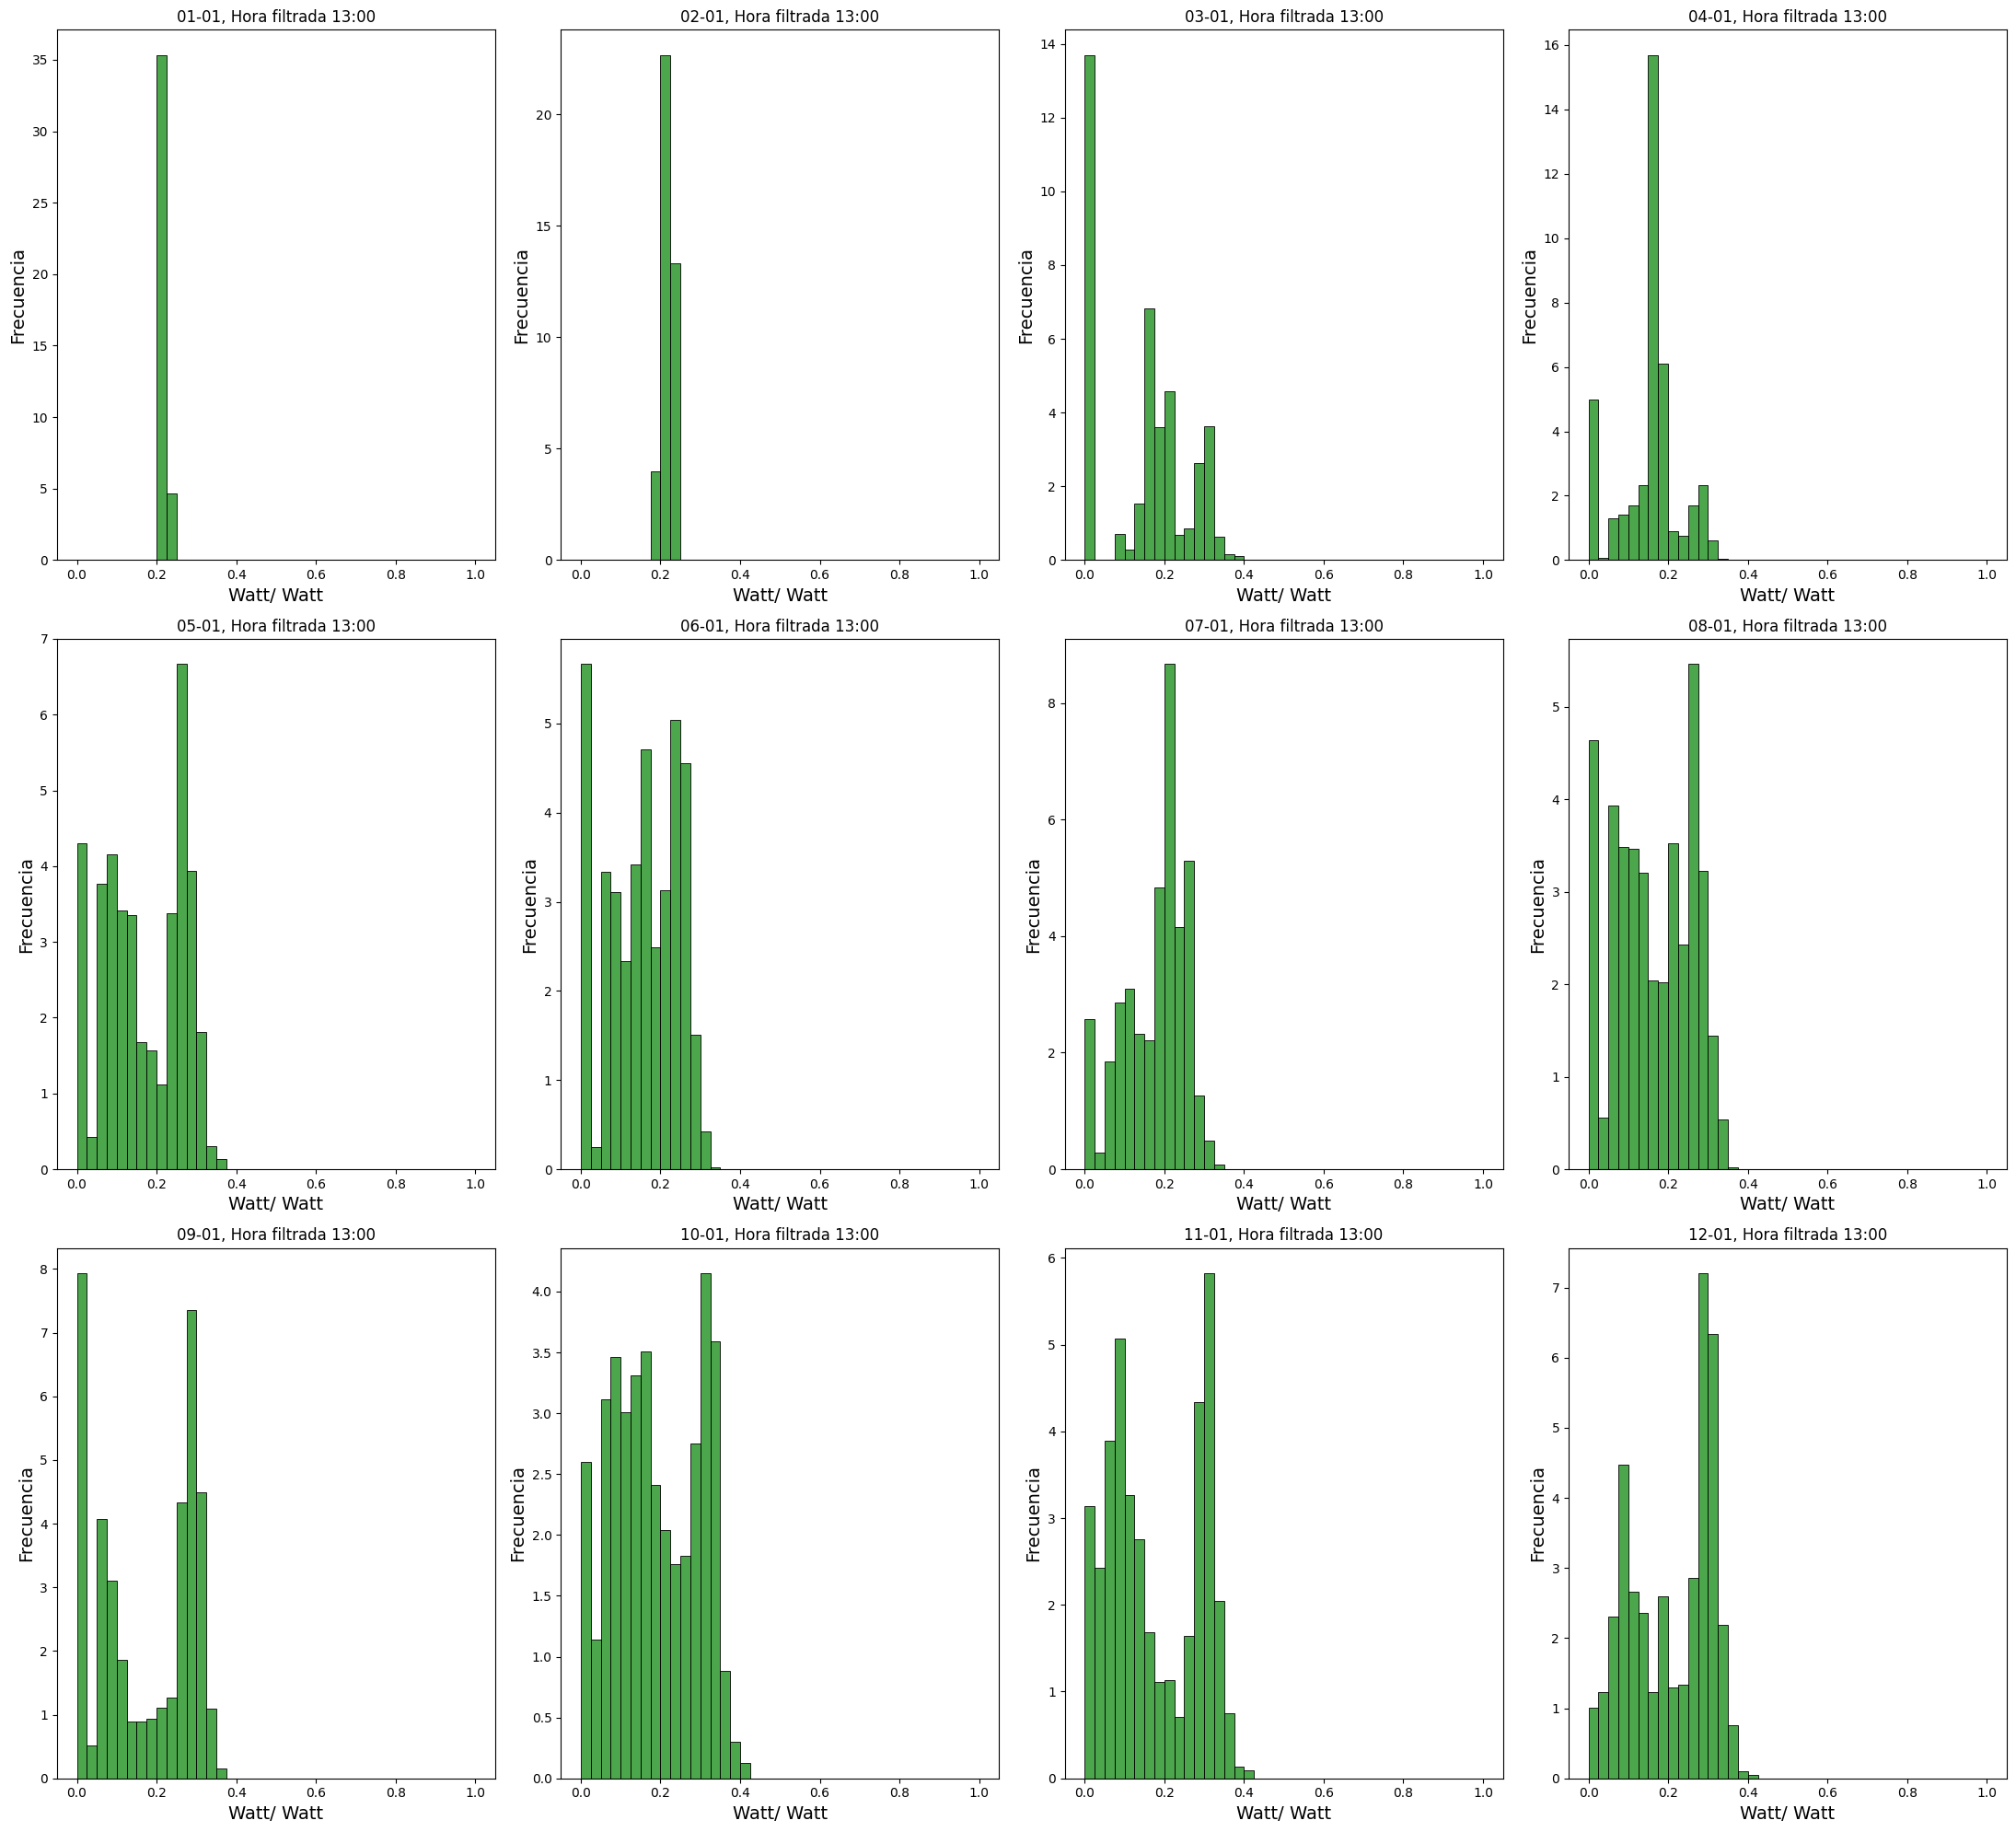

/Users/brianrodriguez/Documents/Economia/Data/AnP01_
['AnP01_Sol_PV_2022.xlsx', 'AnP01_Sol_PV_2023.xlsx', 'AnP01_Sol_PV_2021.xlsx']


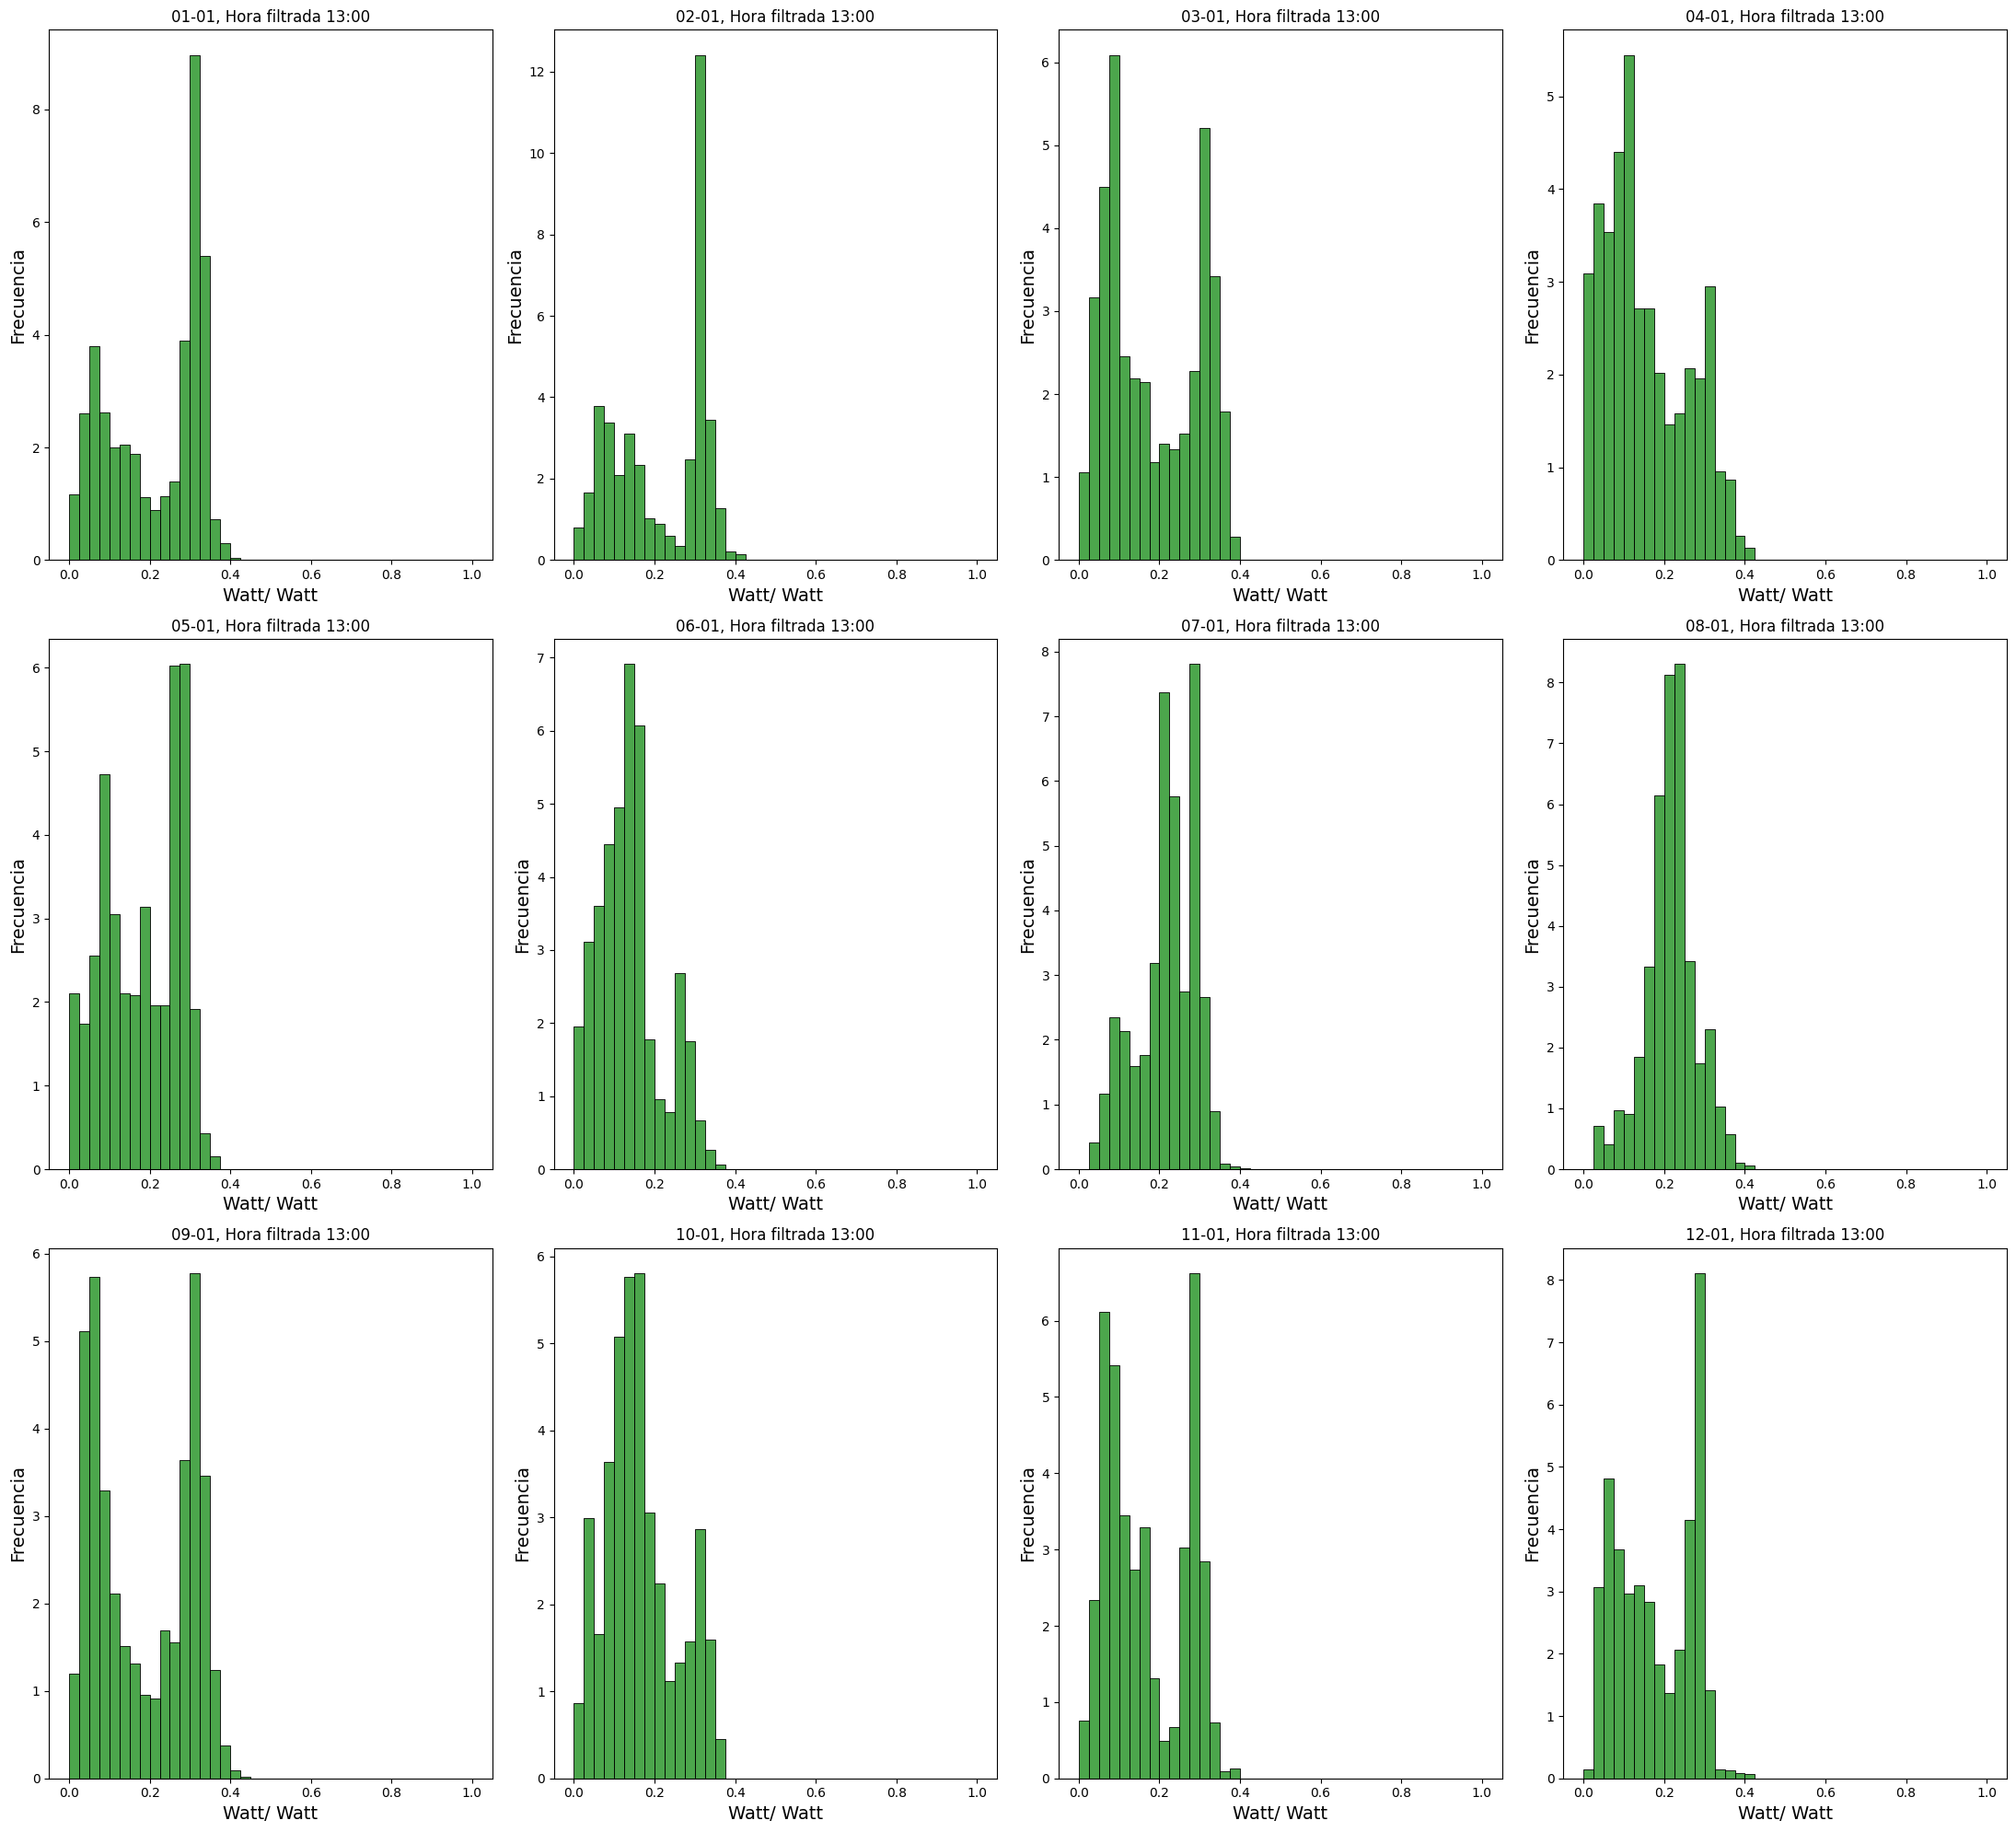

/Users/brianrodriguez/Documents/Economia/Data/AnP01_
['AnP01_Sol_PV_2022.xlsx', 'AnP01_Sol_PV_2023.xlsx', 'AnP01_Sol_PV_2021.xlsx']


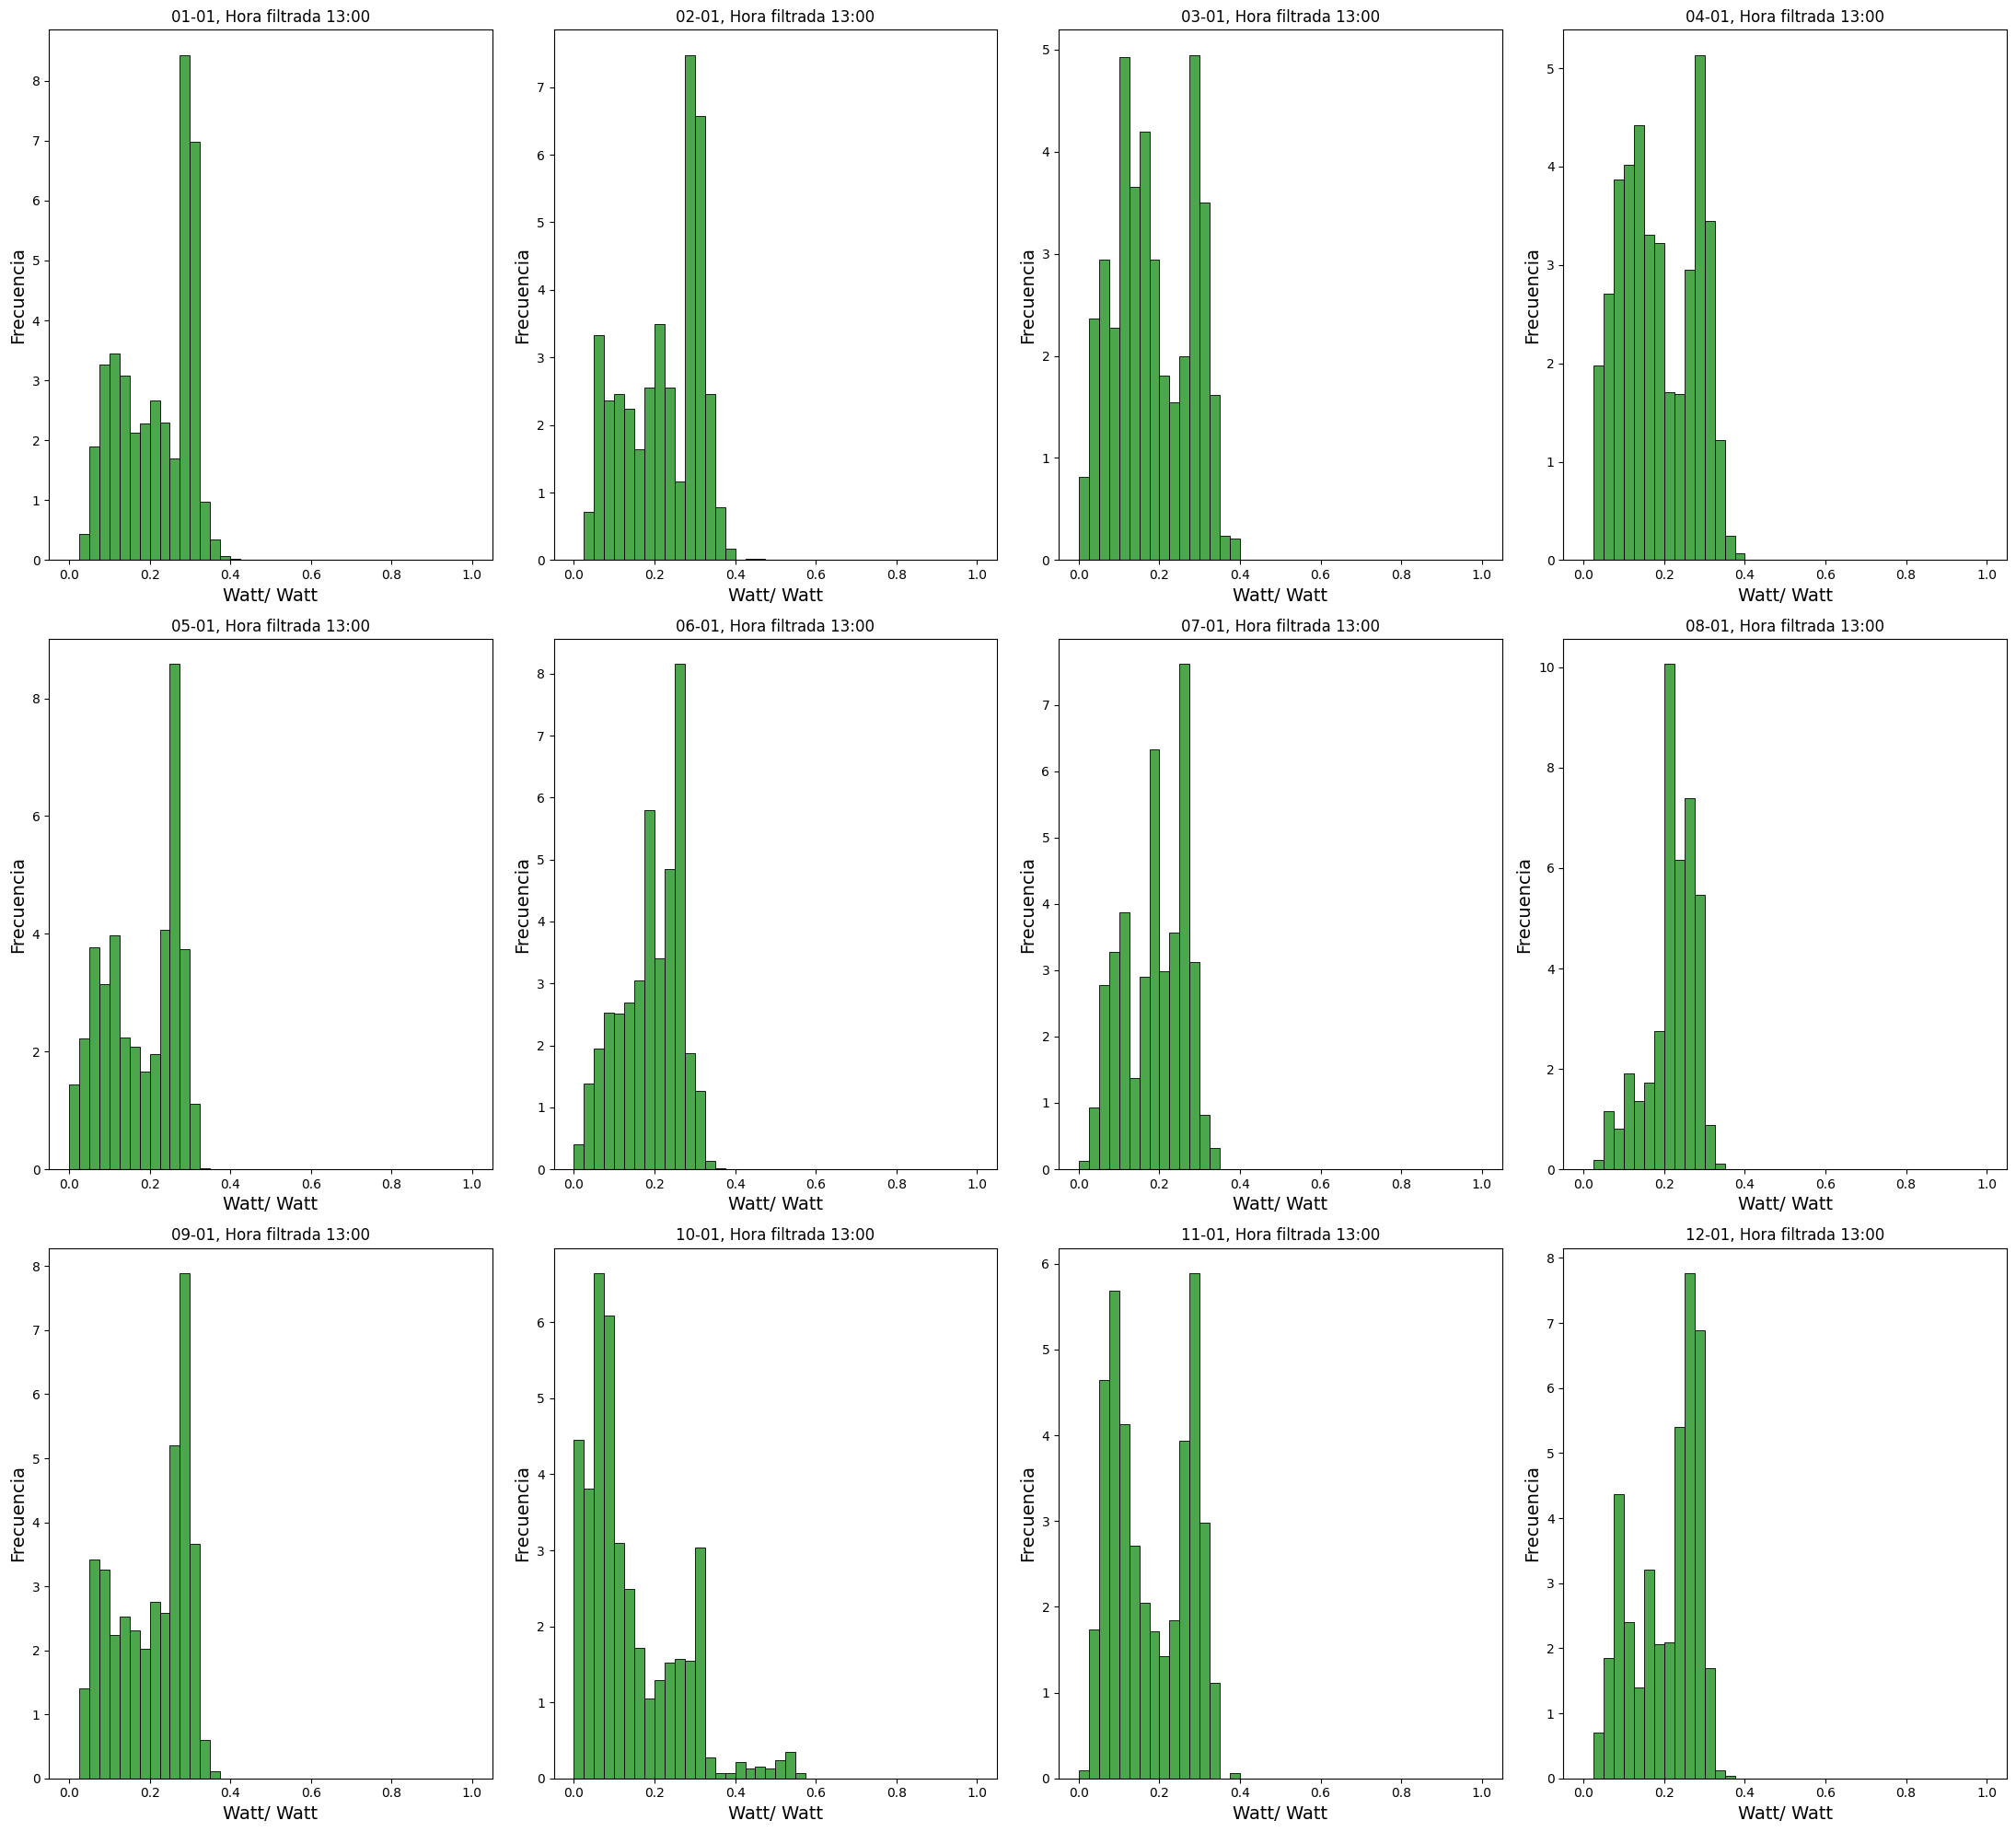

/Users/brianrodriguez/Documents/Economia/Data/AnP03_
['AnP03_Sol_PV_2021.xlsx', 'AnP03_Sol_PV_2022.xlsx', 'AnP03_Sol_PV_2023.xlsx']


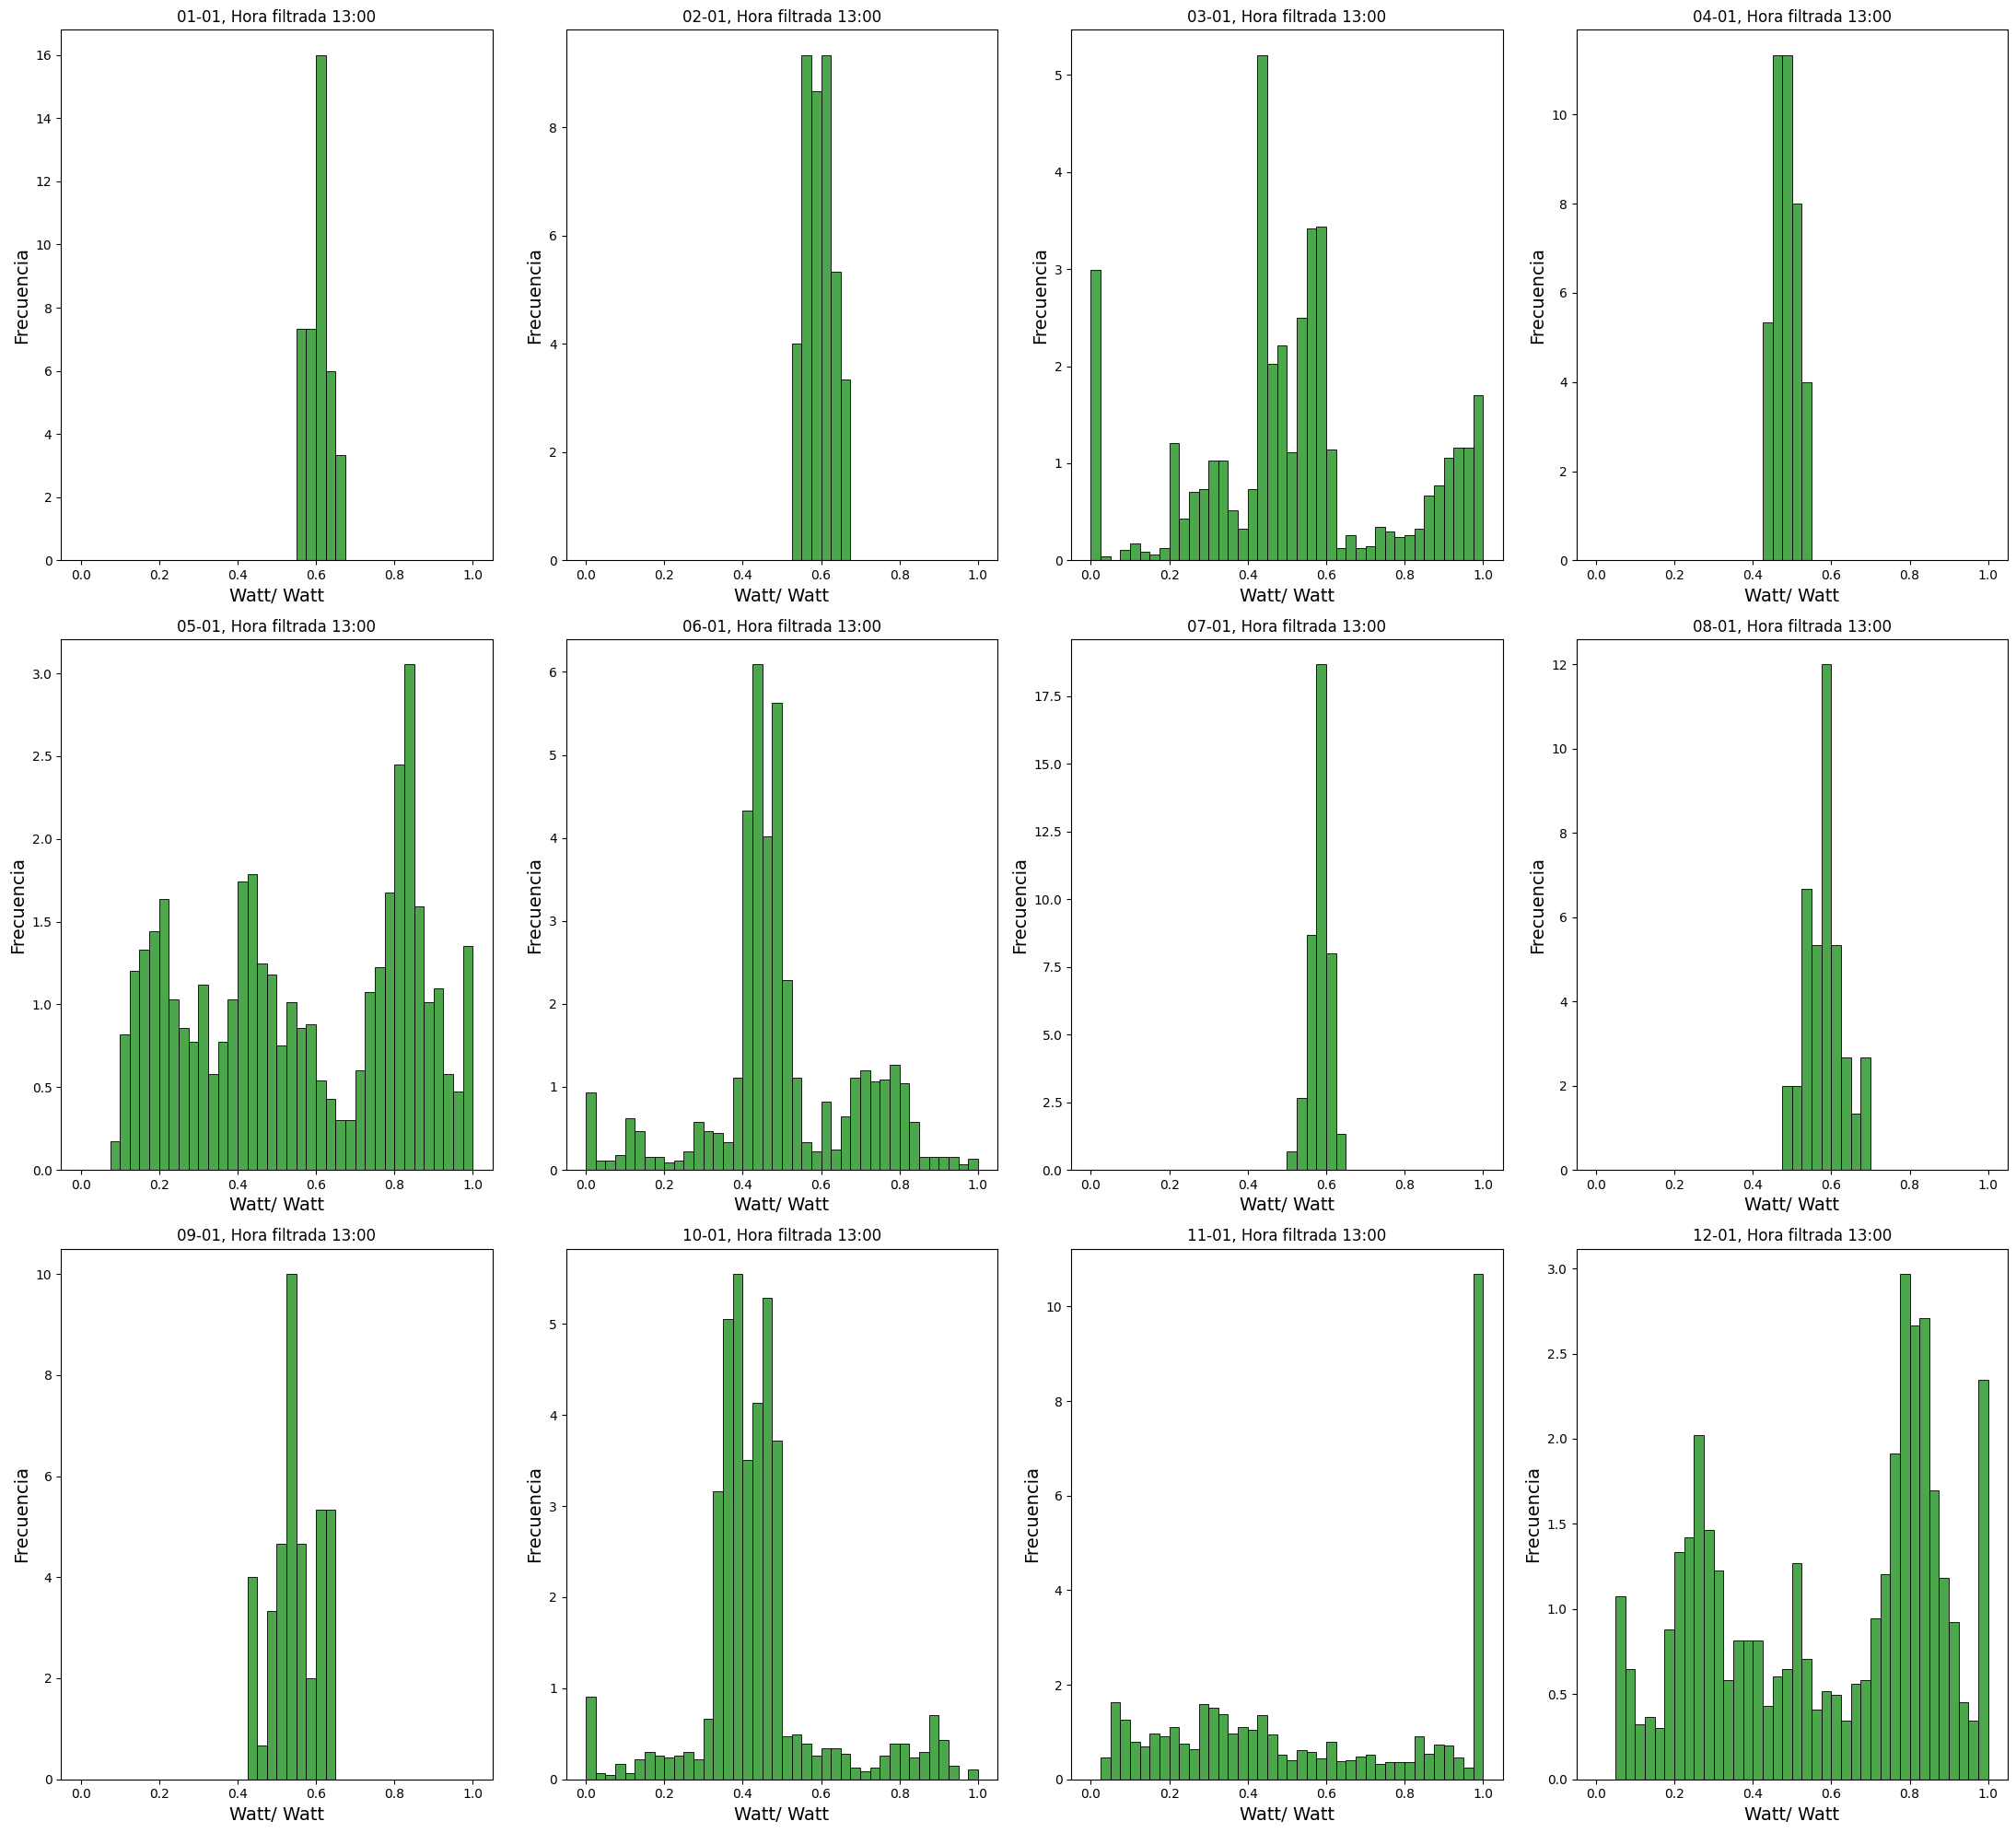

/Users/brianrodriguez/Documents/Economia/Data/AnP03_
['AnP03_Sol_PV_2021.xlsx', 'AnP03_Sol_PV_2022.xlsx', 'AnP03_Sol_PV_2023.xlsx']


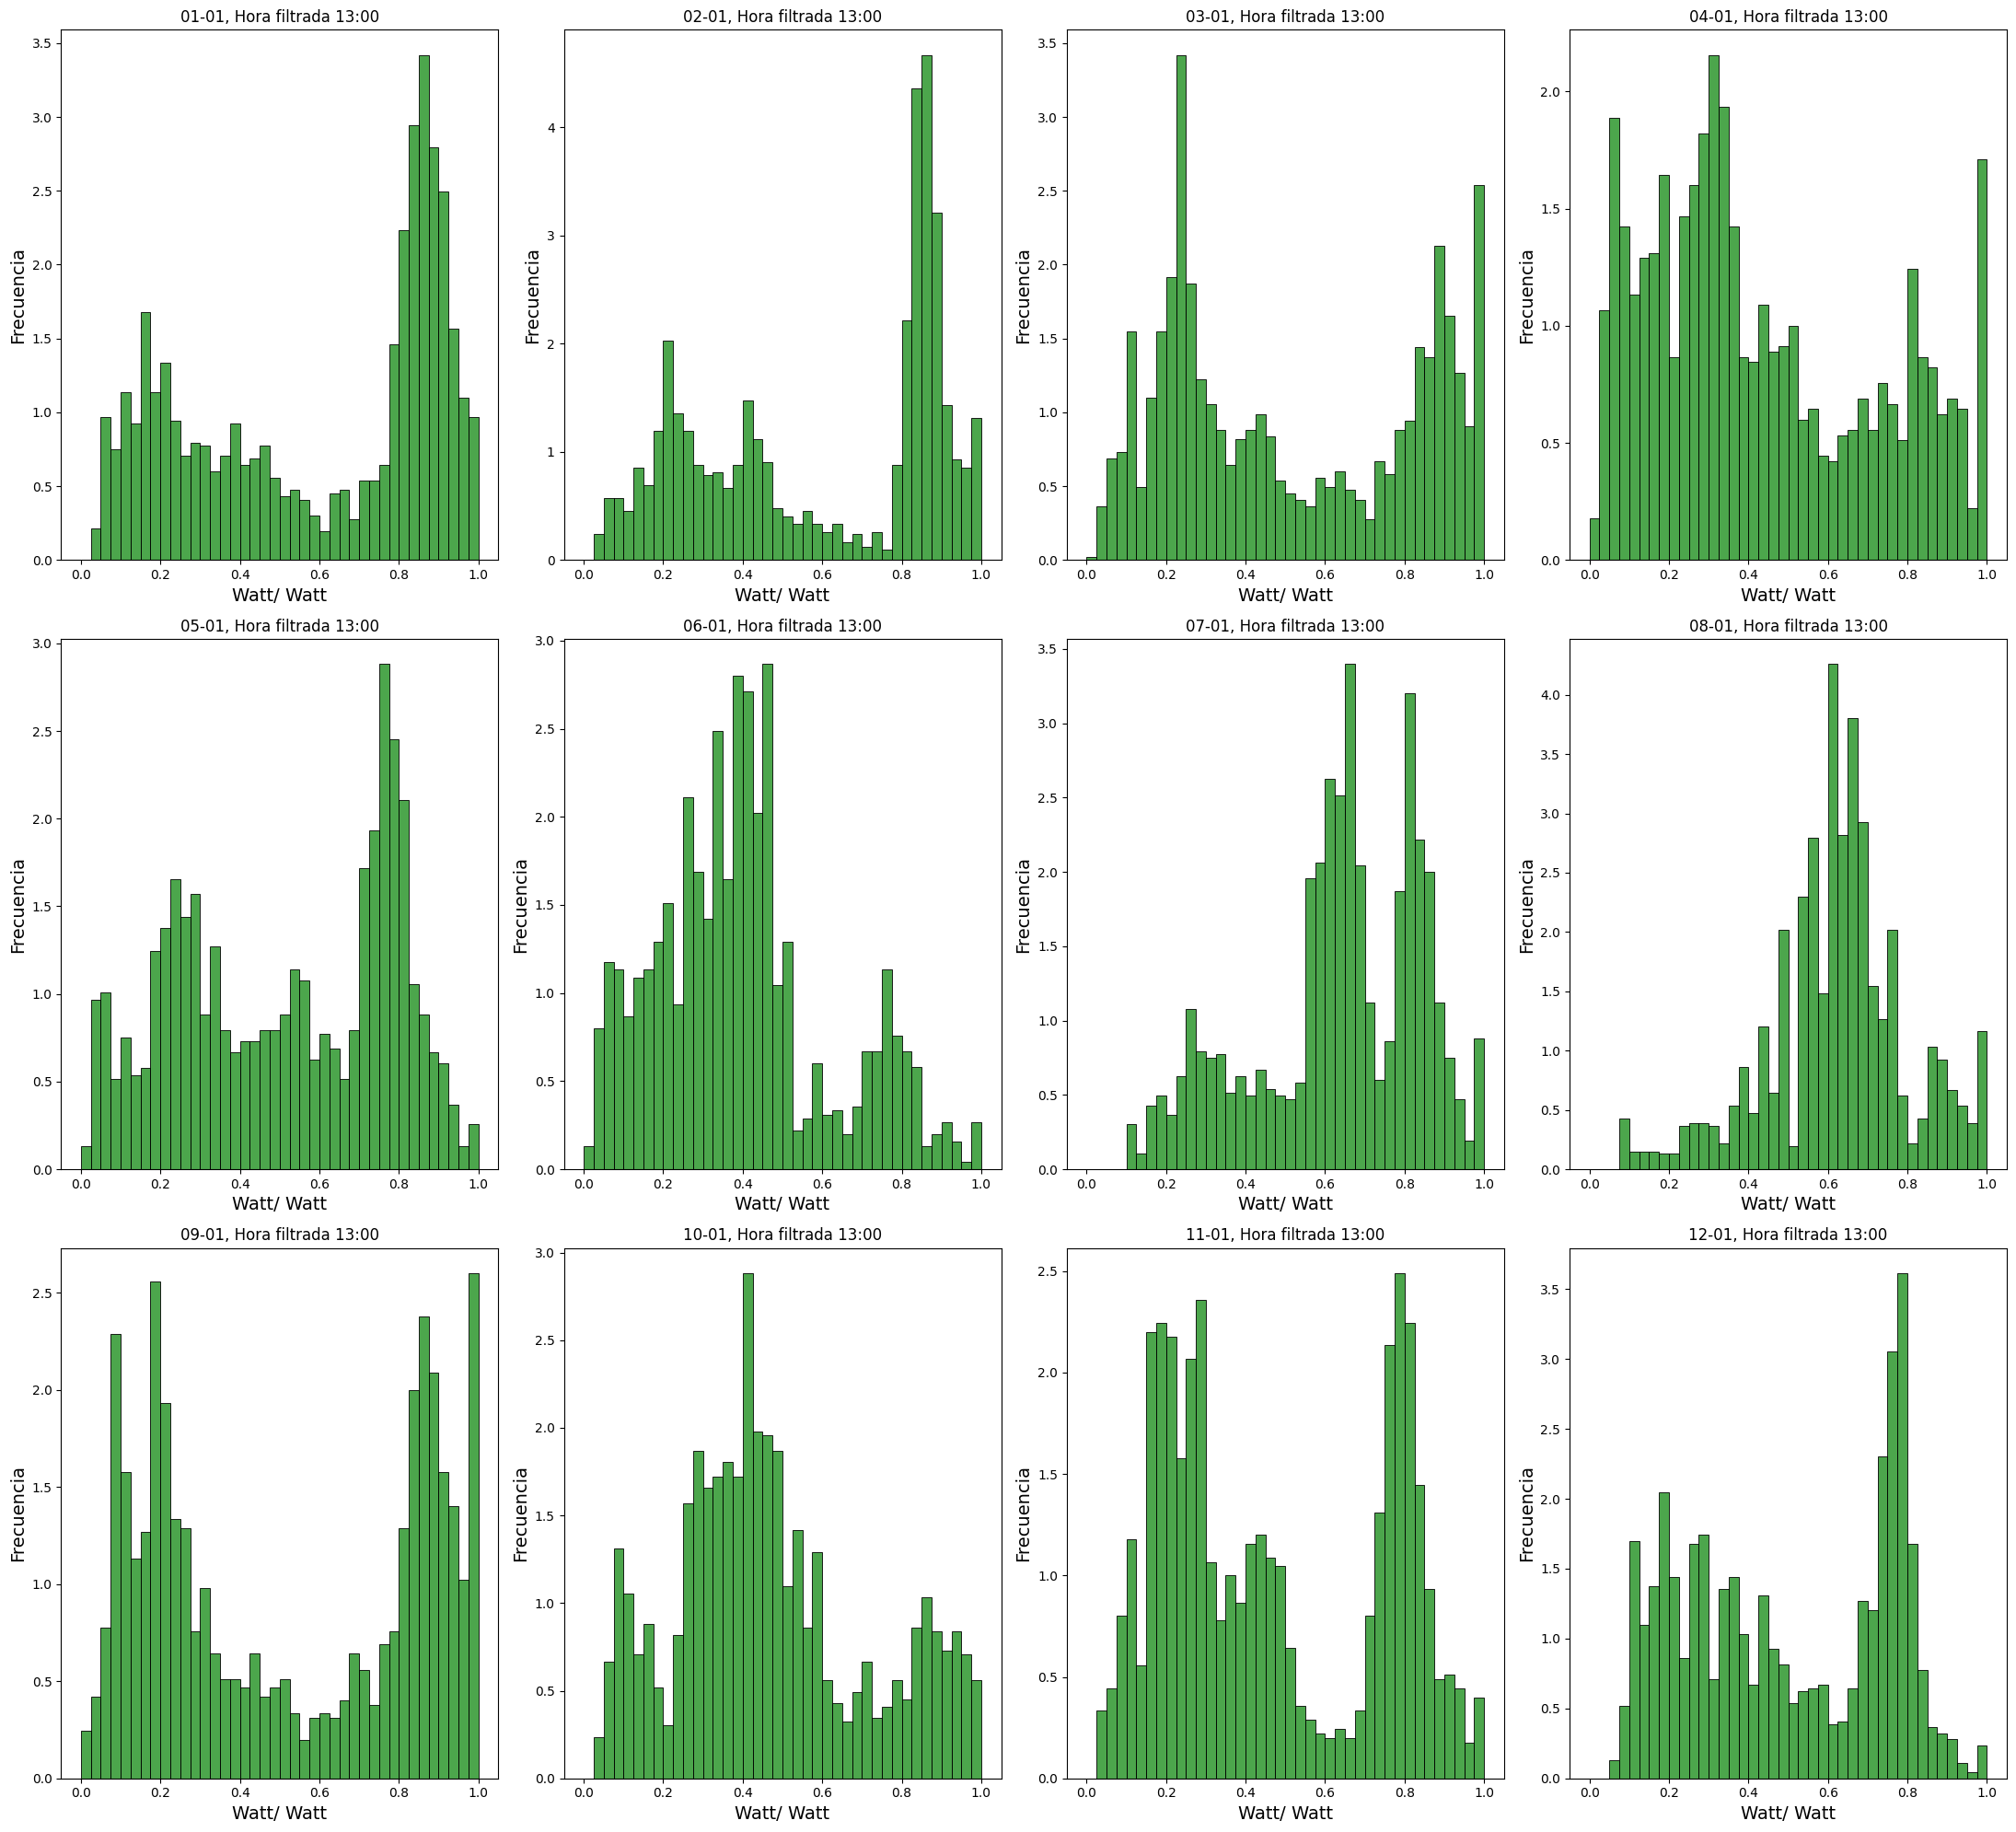

/Users/brianrodriguez/Documents/Economia/Data/AnP03_
['AnP03_Sol_PV_2021.xlsx', 'AnP03_Sol_PV_2022.xlsx', 'AnP03_Sol_PV_2023.xlsx']


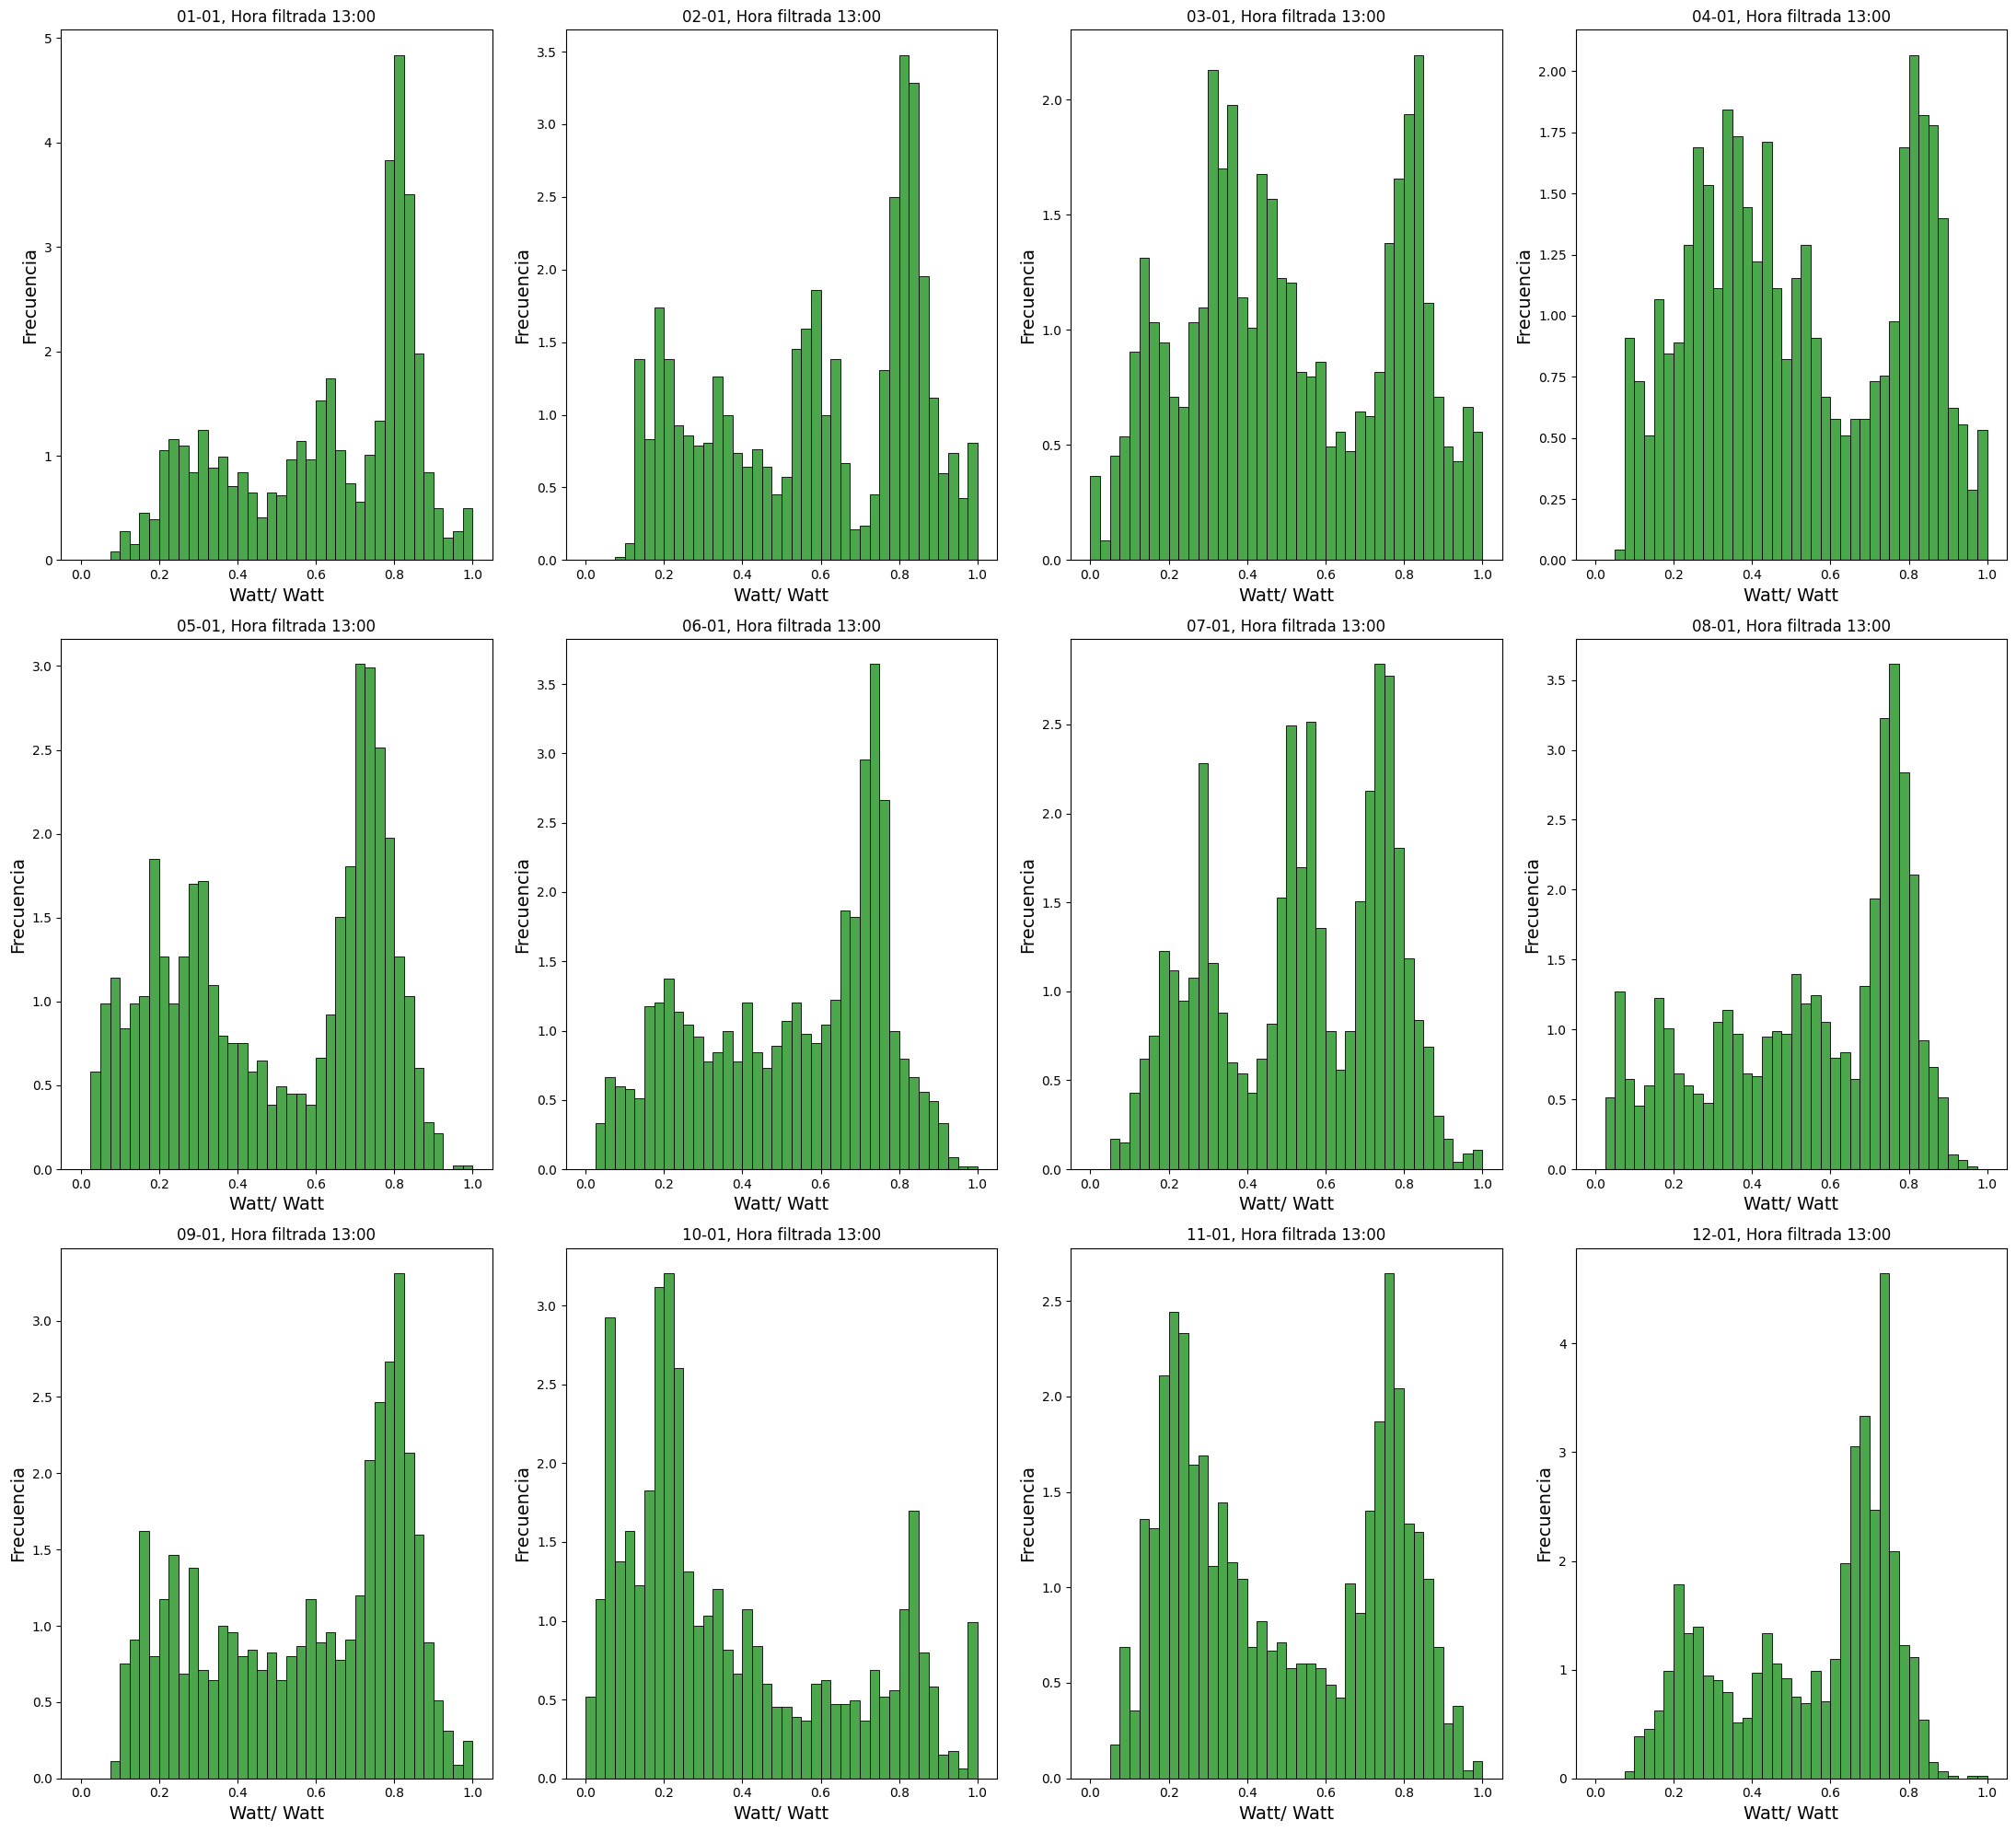

/Users/brianrodriguez/Documents/Economia/Data/AnP04_
['AnP04_Sol_PV_2023.xlsx', 'AnP04_Sol_PV_2022.xlsx', 'AnP04_Sol_PV_2021.xlsx']


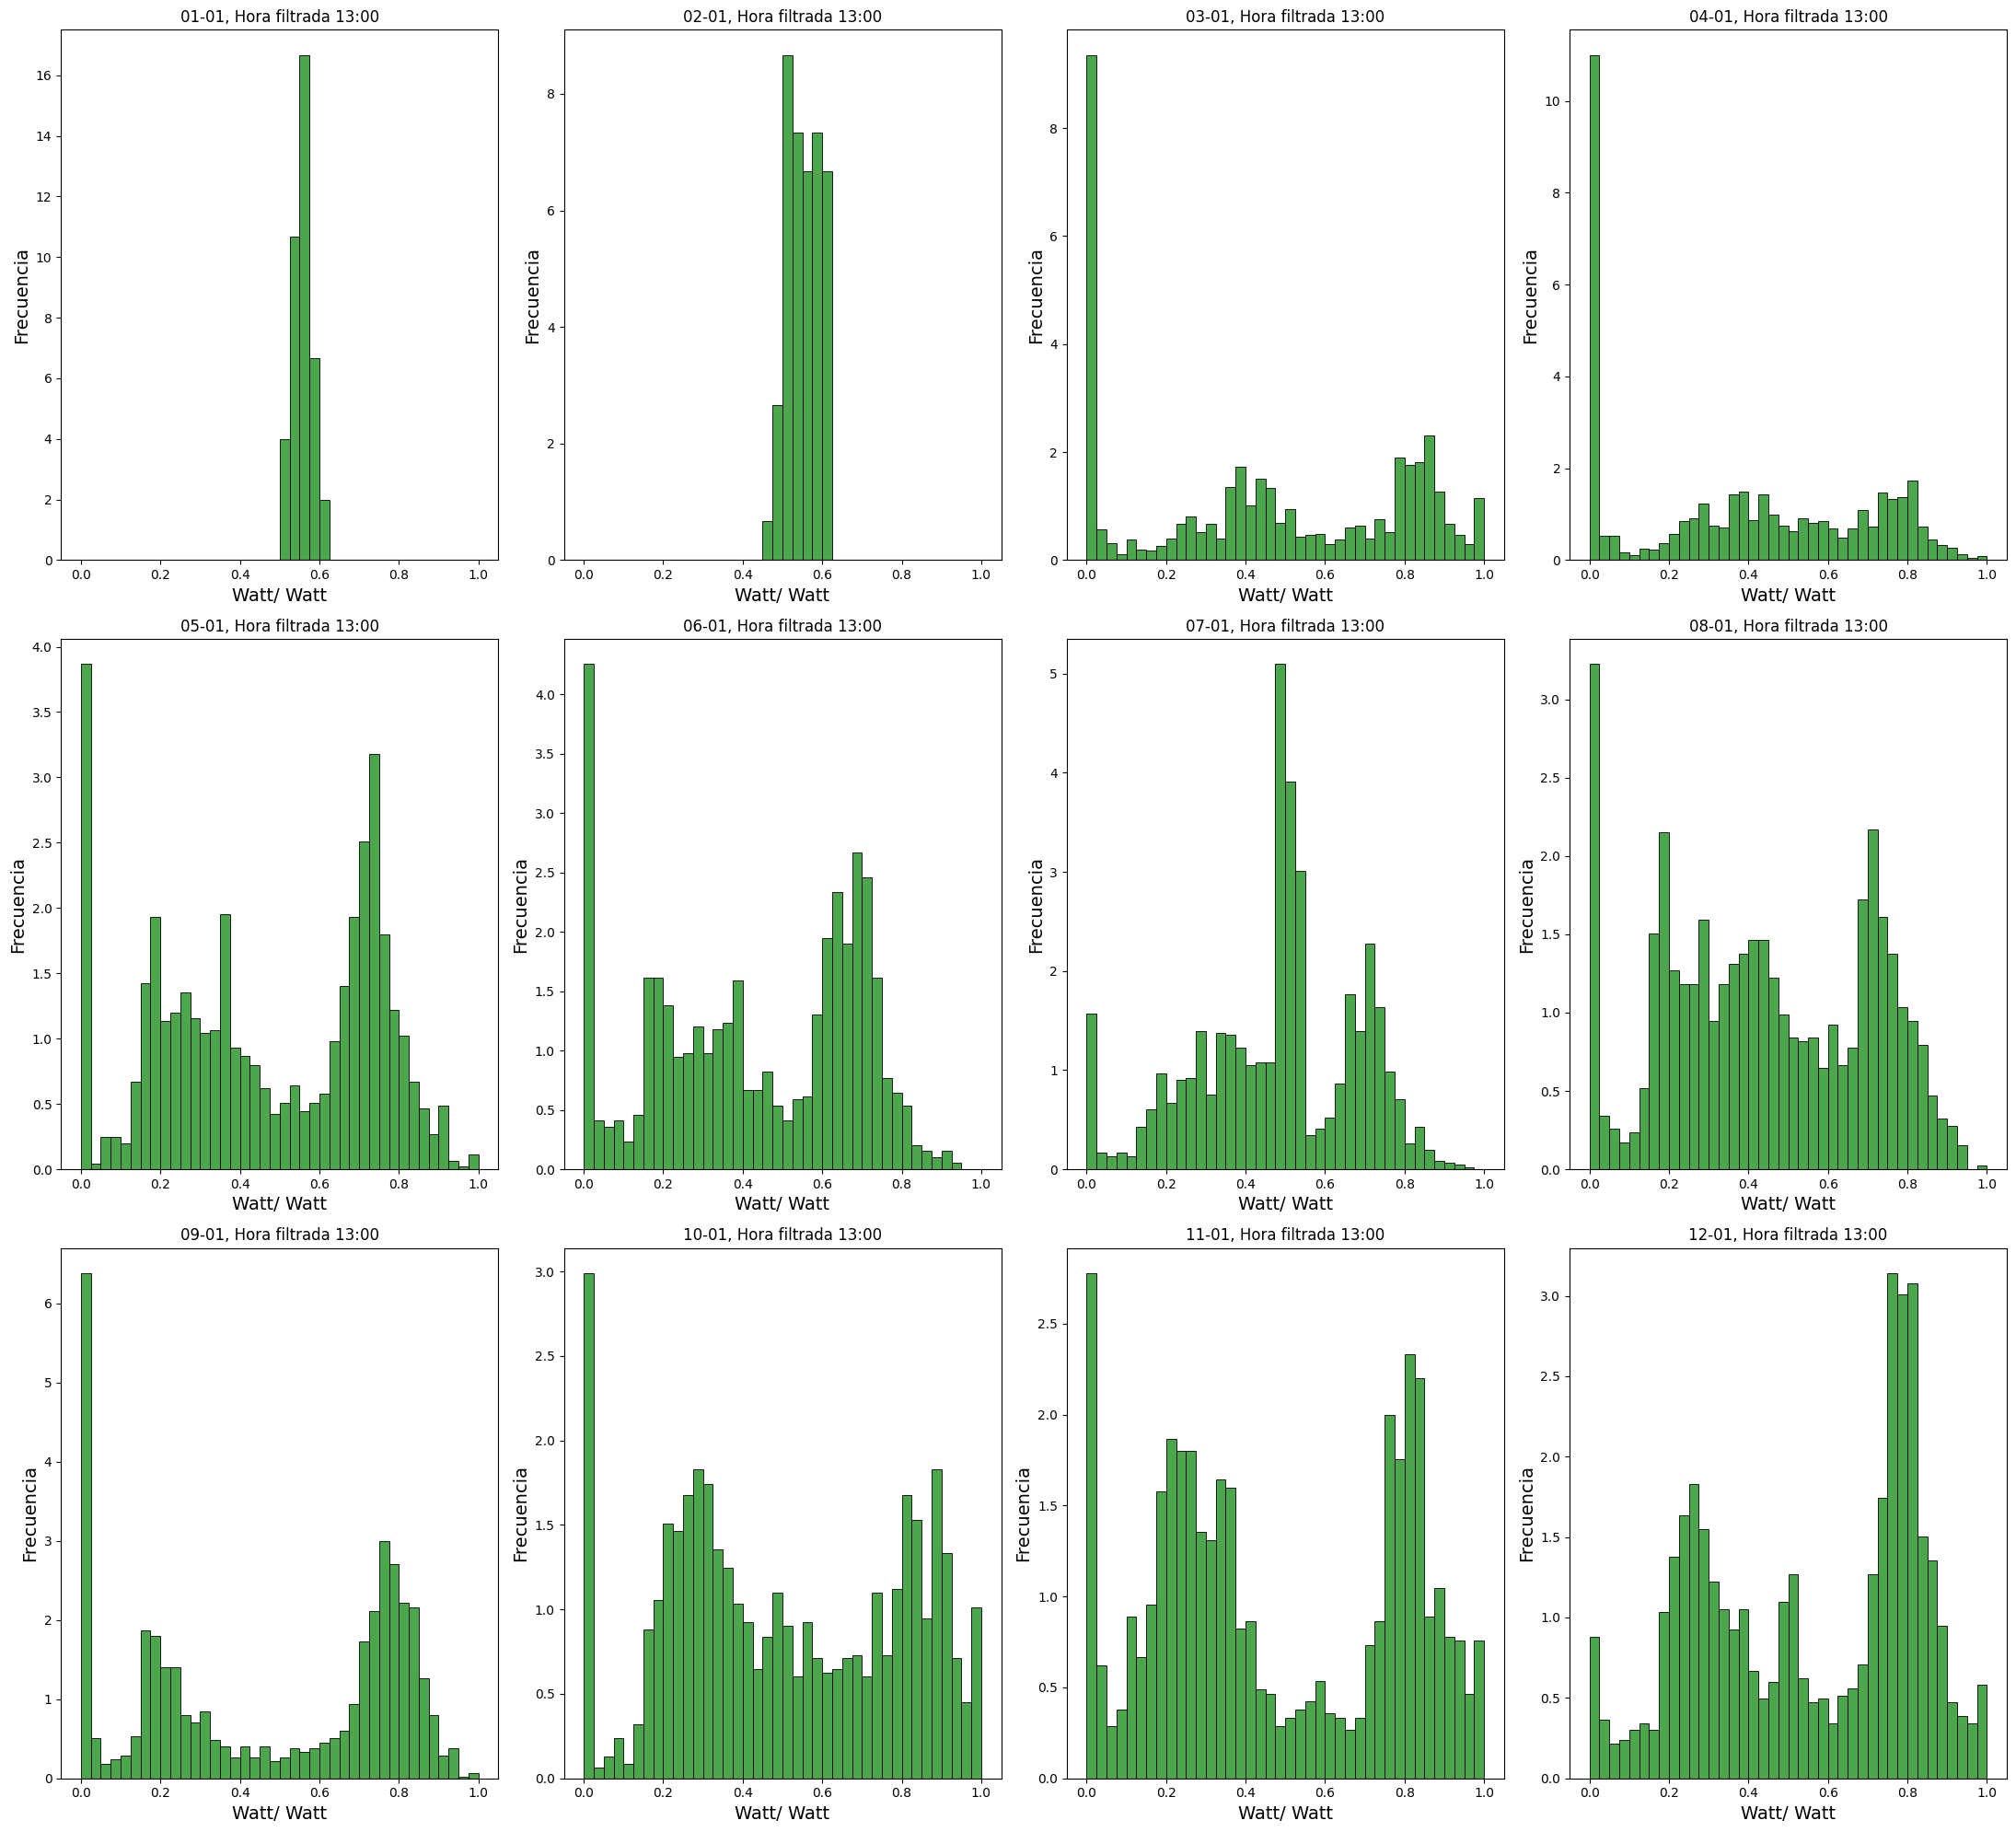

/Users/brianrodriguez/Documents/Economia/Data/AnP04_
['AnP04_Sol_PV_2023.xlsx', 'AnP04_Sol_PV_2022.xlsx', 'AnP04_Sol_PV_2021.xlsx']


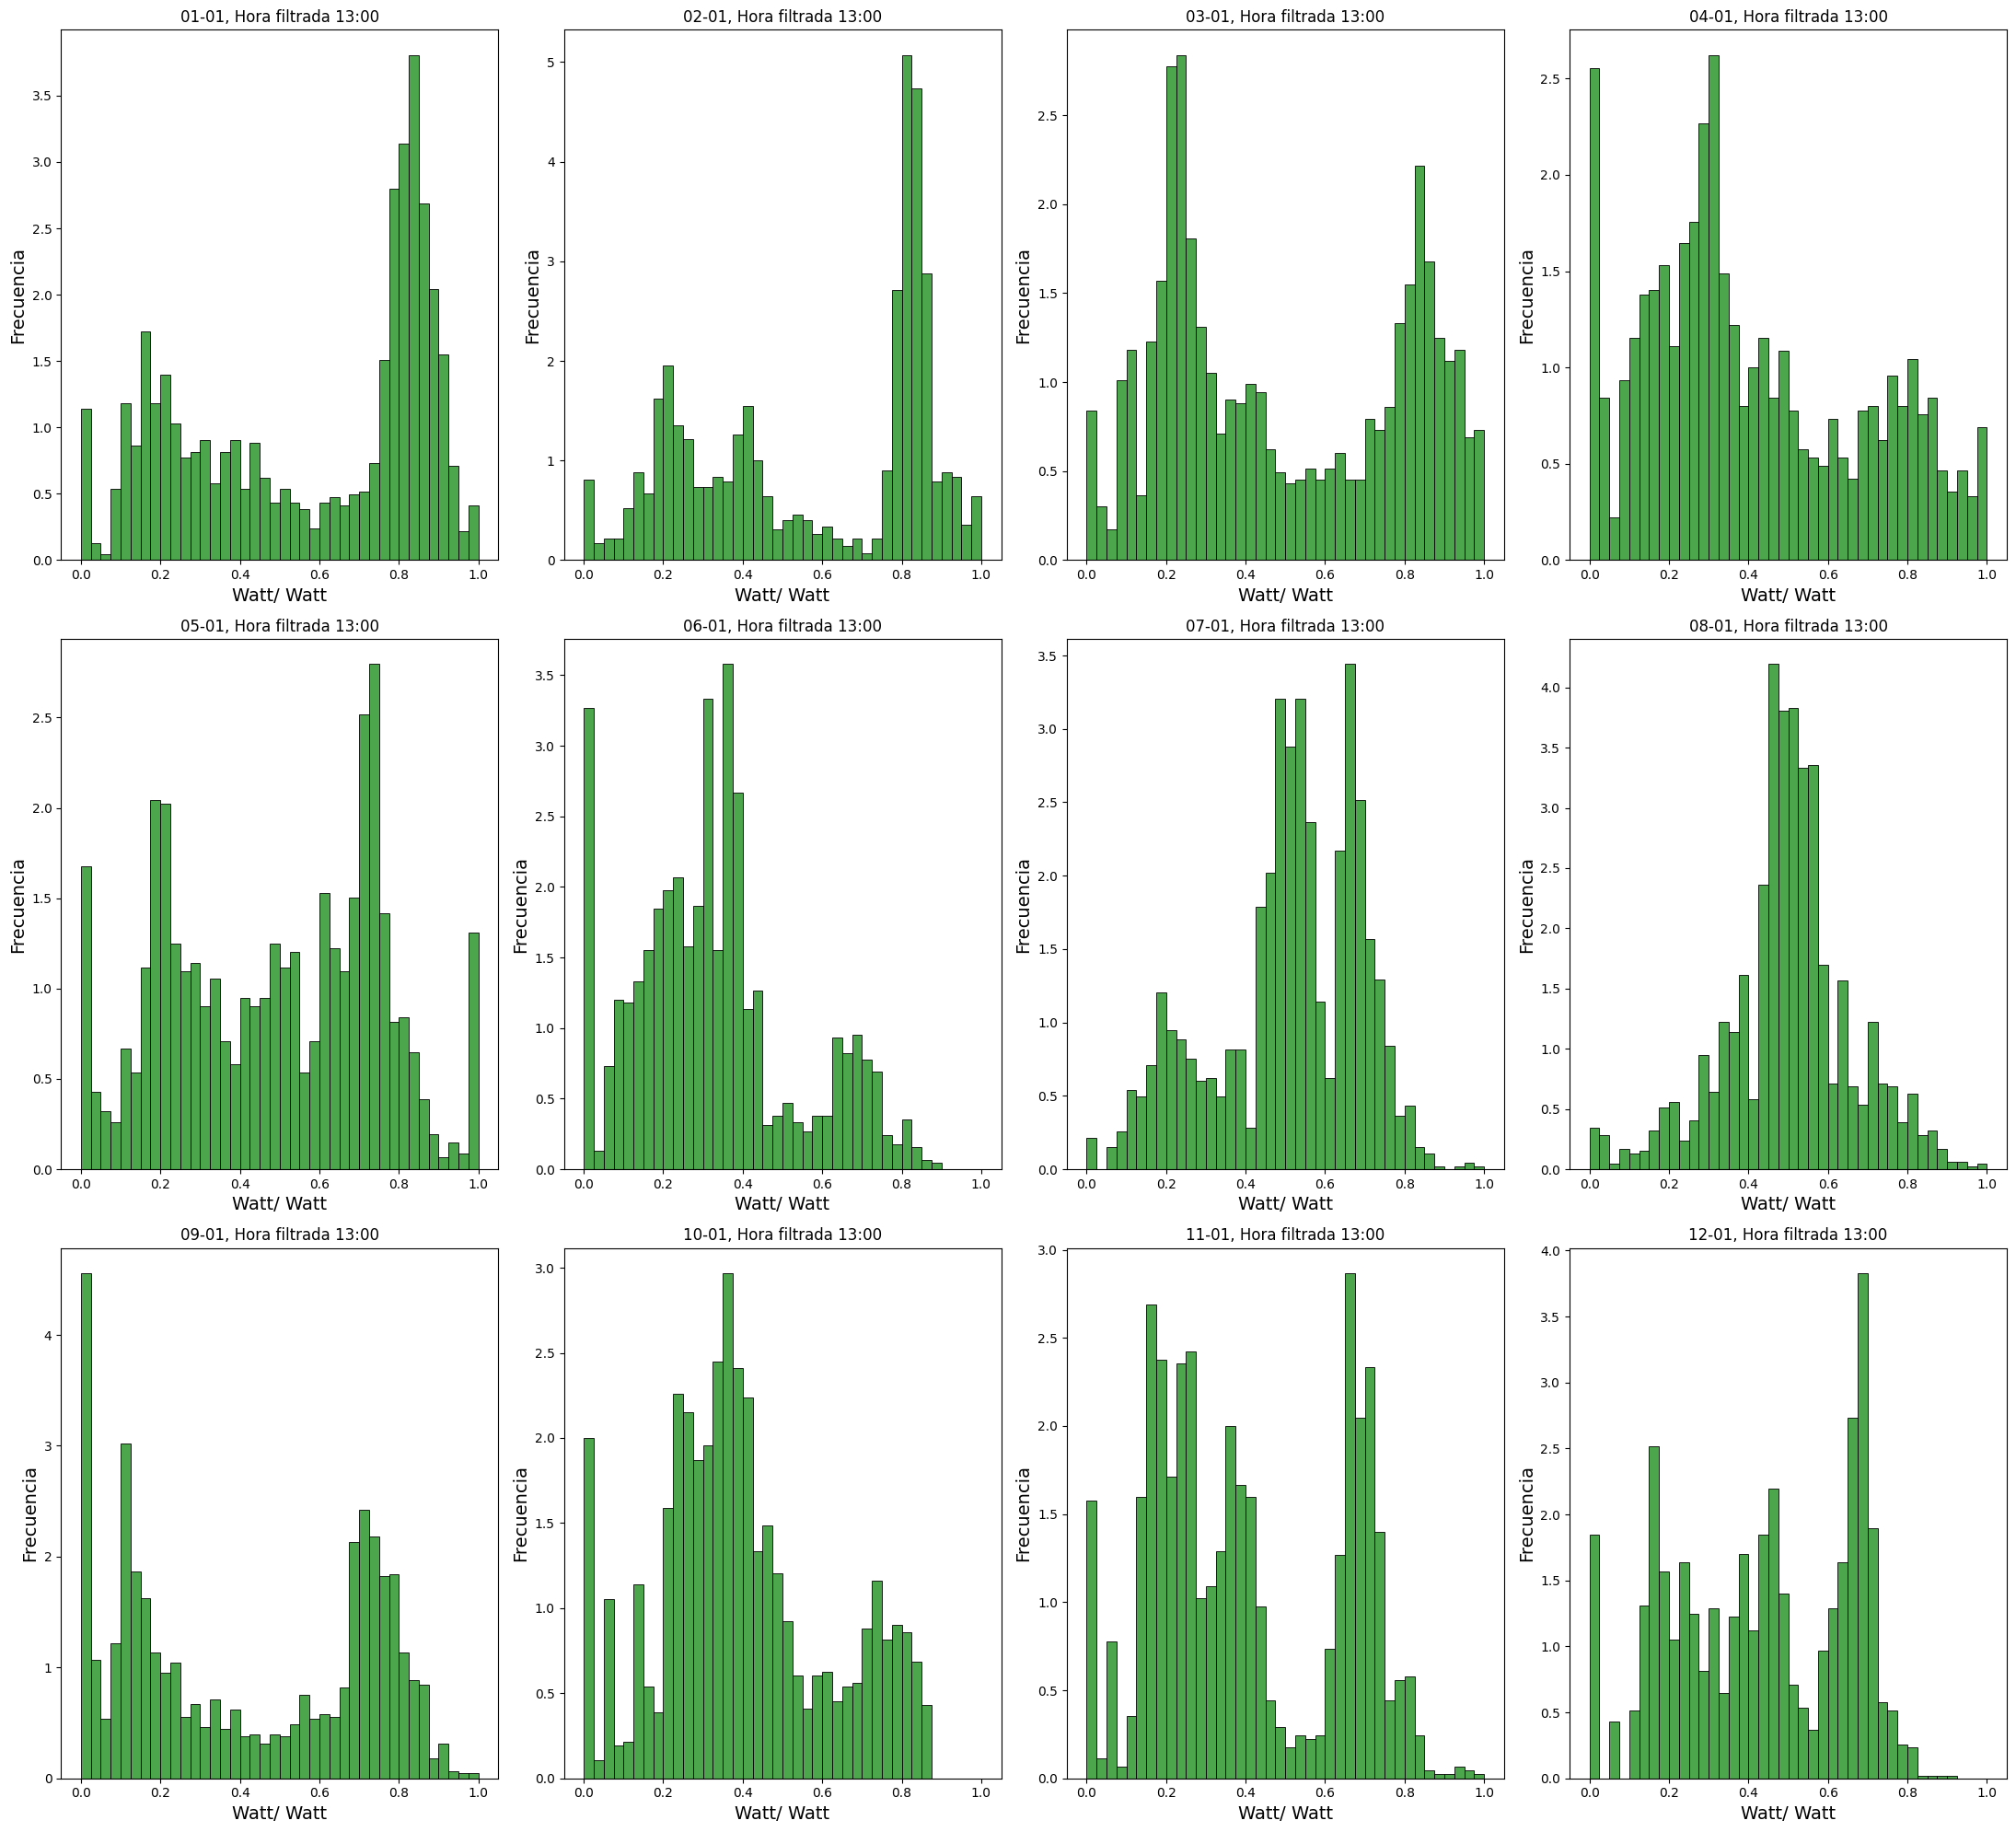

/Users/brianrodriguez/Documents/Economia/Data/AnP04_
['AnP04_Sol_PV_2023.xlsx', 'AnP04_Sol_PV_2022.xlsx', 'AnP04_Sol_PV_2021.xlsx']


/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


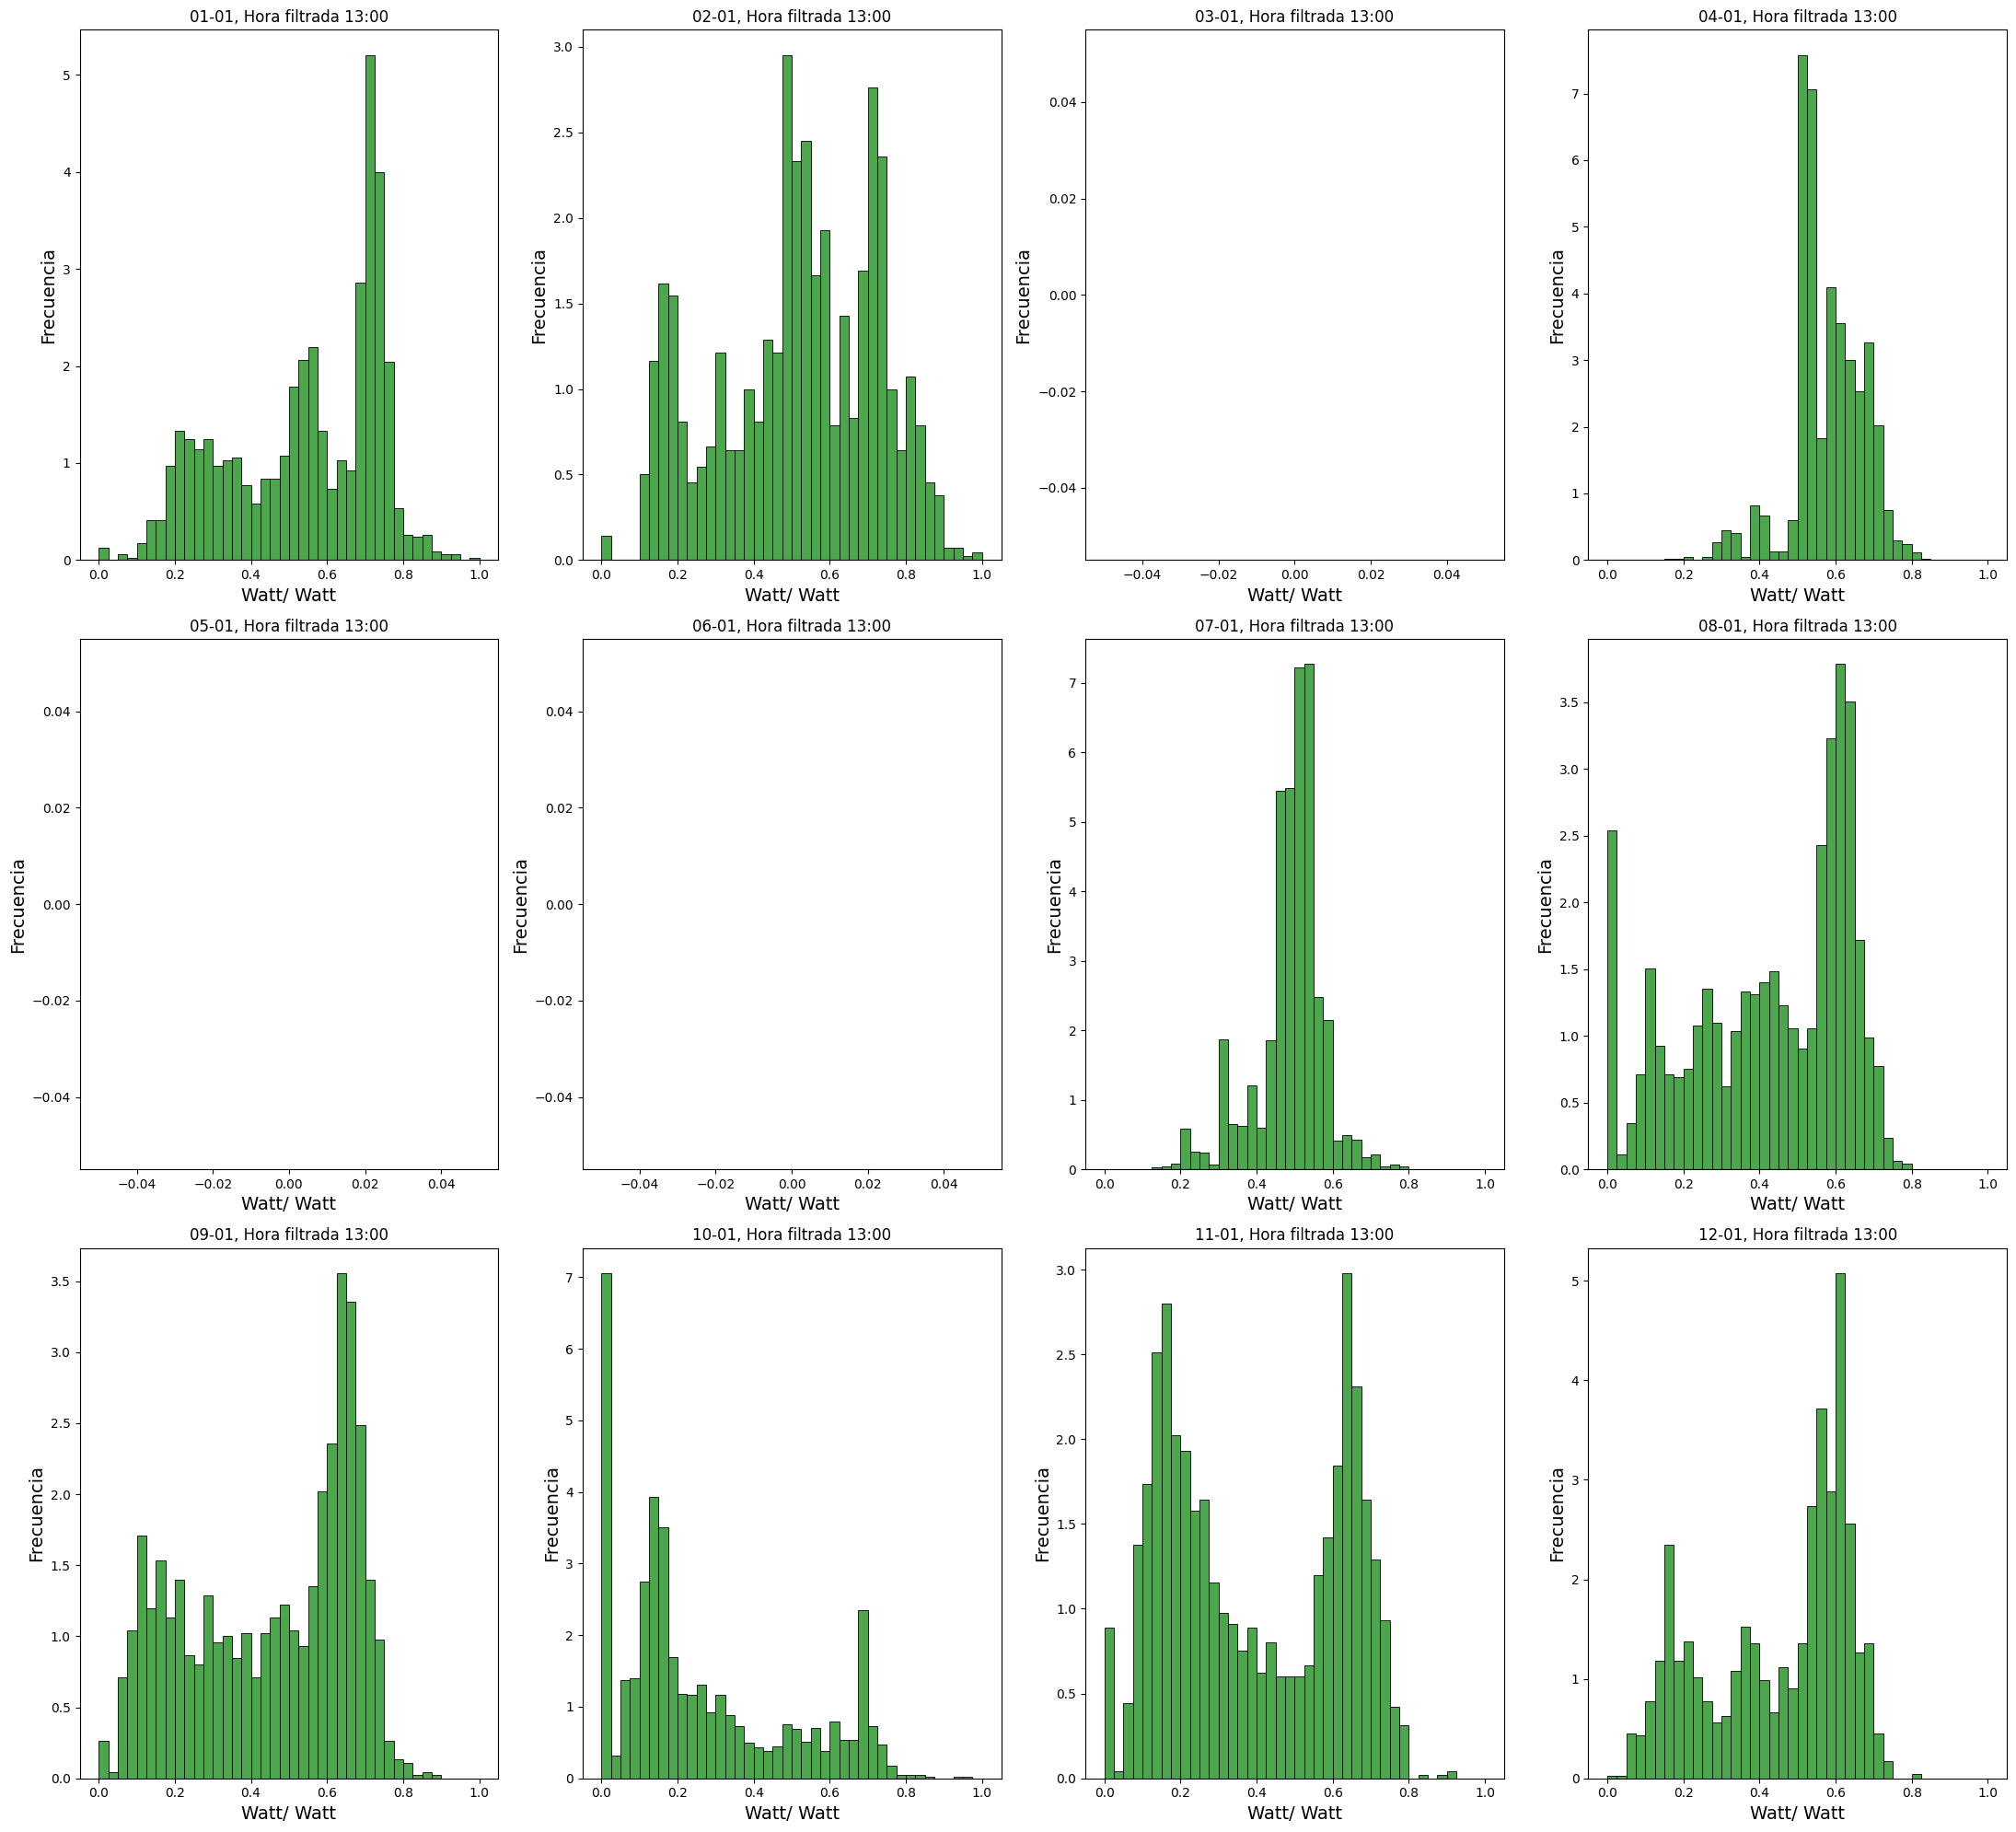

/Users/brianrodriguez/Documents/Economia/Data/AnP10_
['AnP10_Sol_PV_2023.xlsx', 'AnP10_Sol_PV_2022.xlsx', 'AnP10_Sol_PV_2021.xlsx']


/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


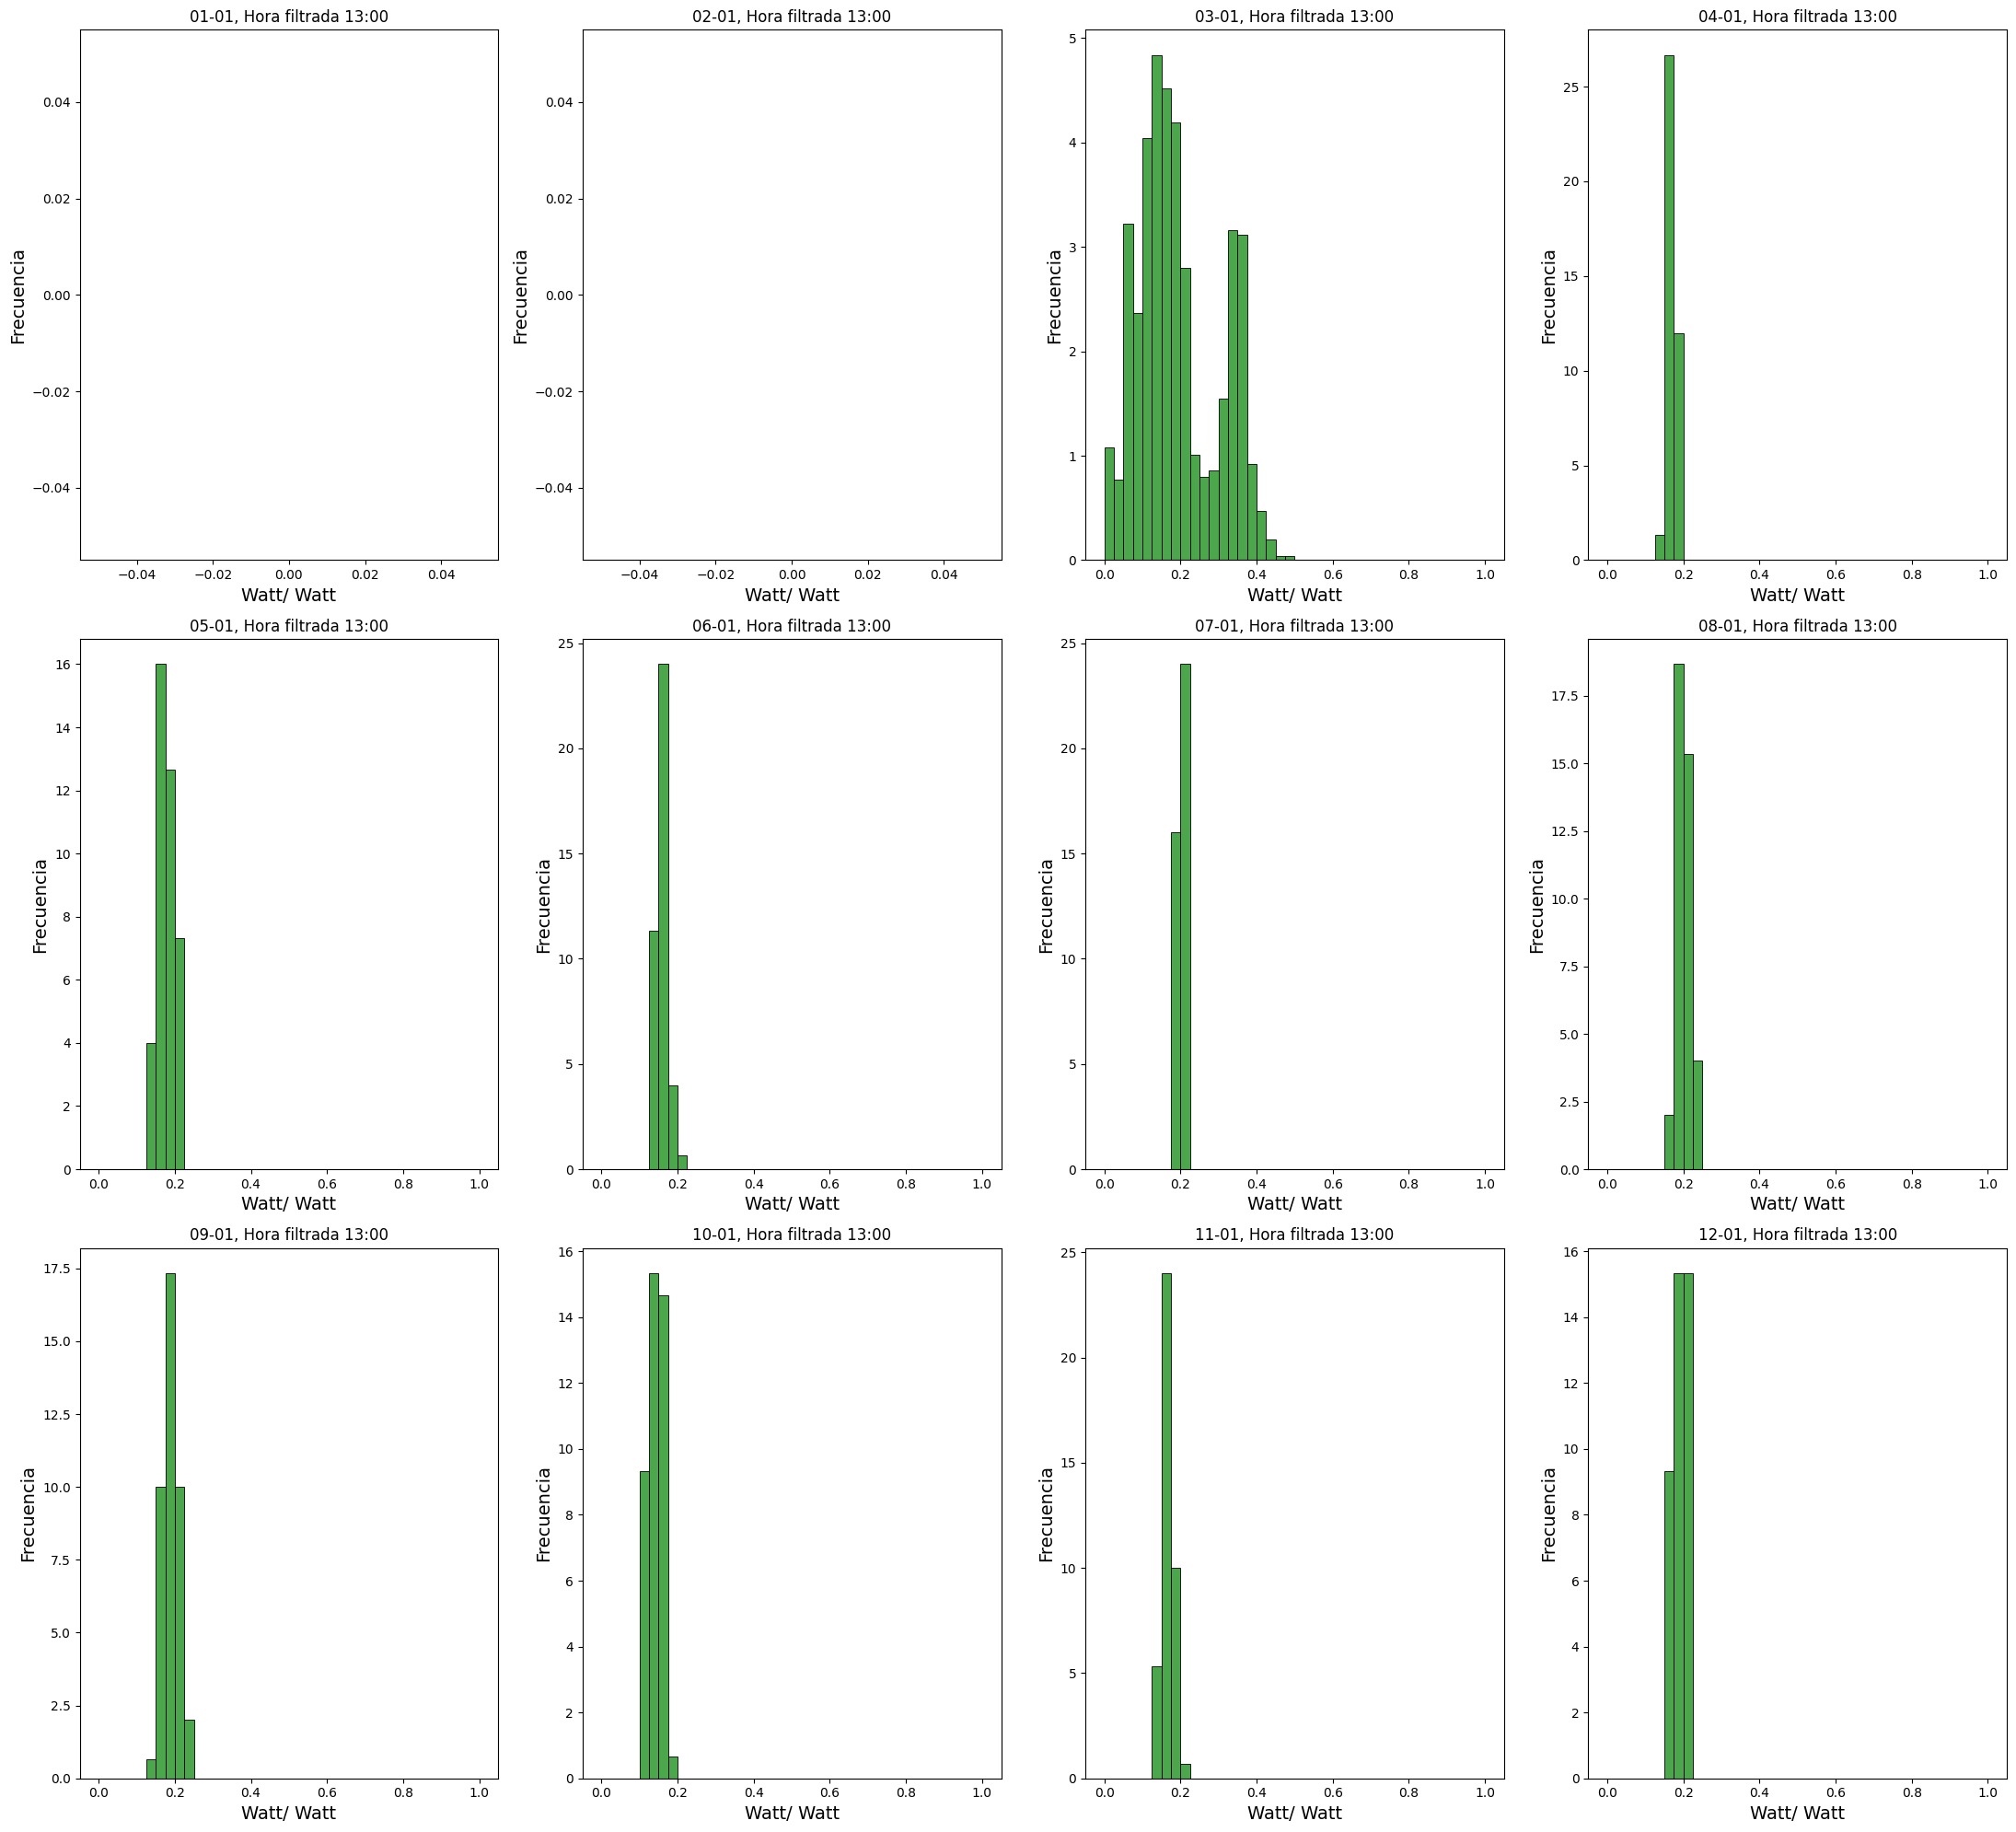

/Users/brianrodriguez/Documents/Economia/Data/AnP10_
['AnP10_Sol_PV_2023.xlsx', 'AnP10_Sol_PV_2022.xlsx', 'AnP10_Sol_PV_2021.xlsx']


/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/brianrodriguez/Documents/Economia/economia/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


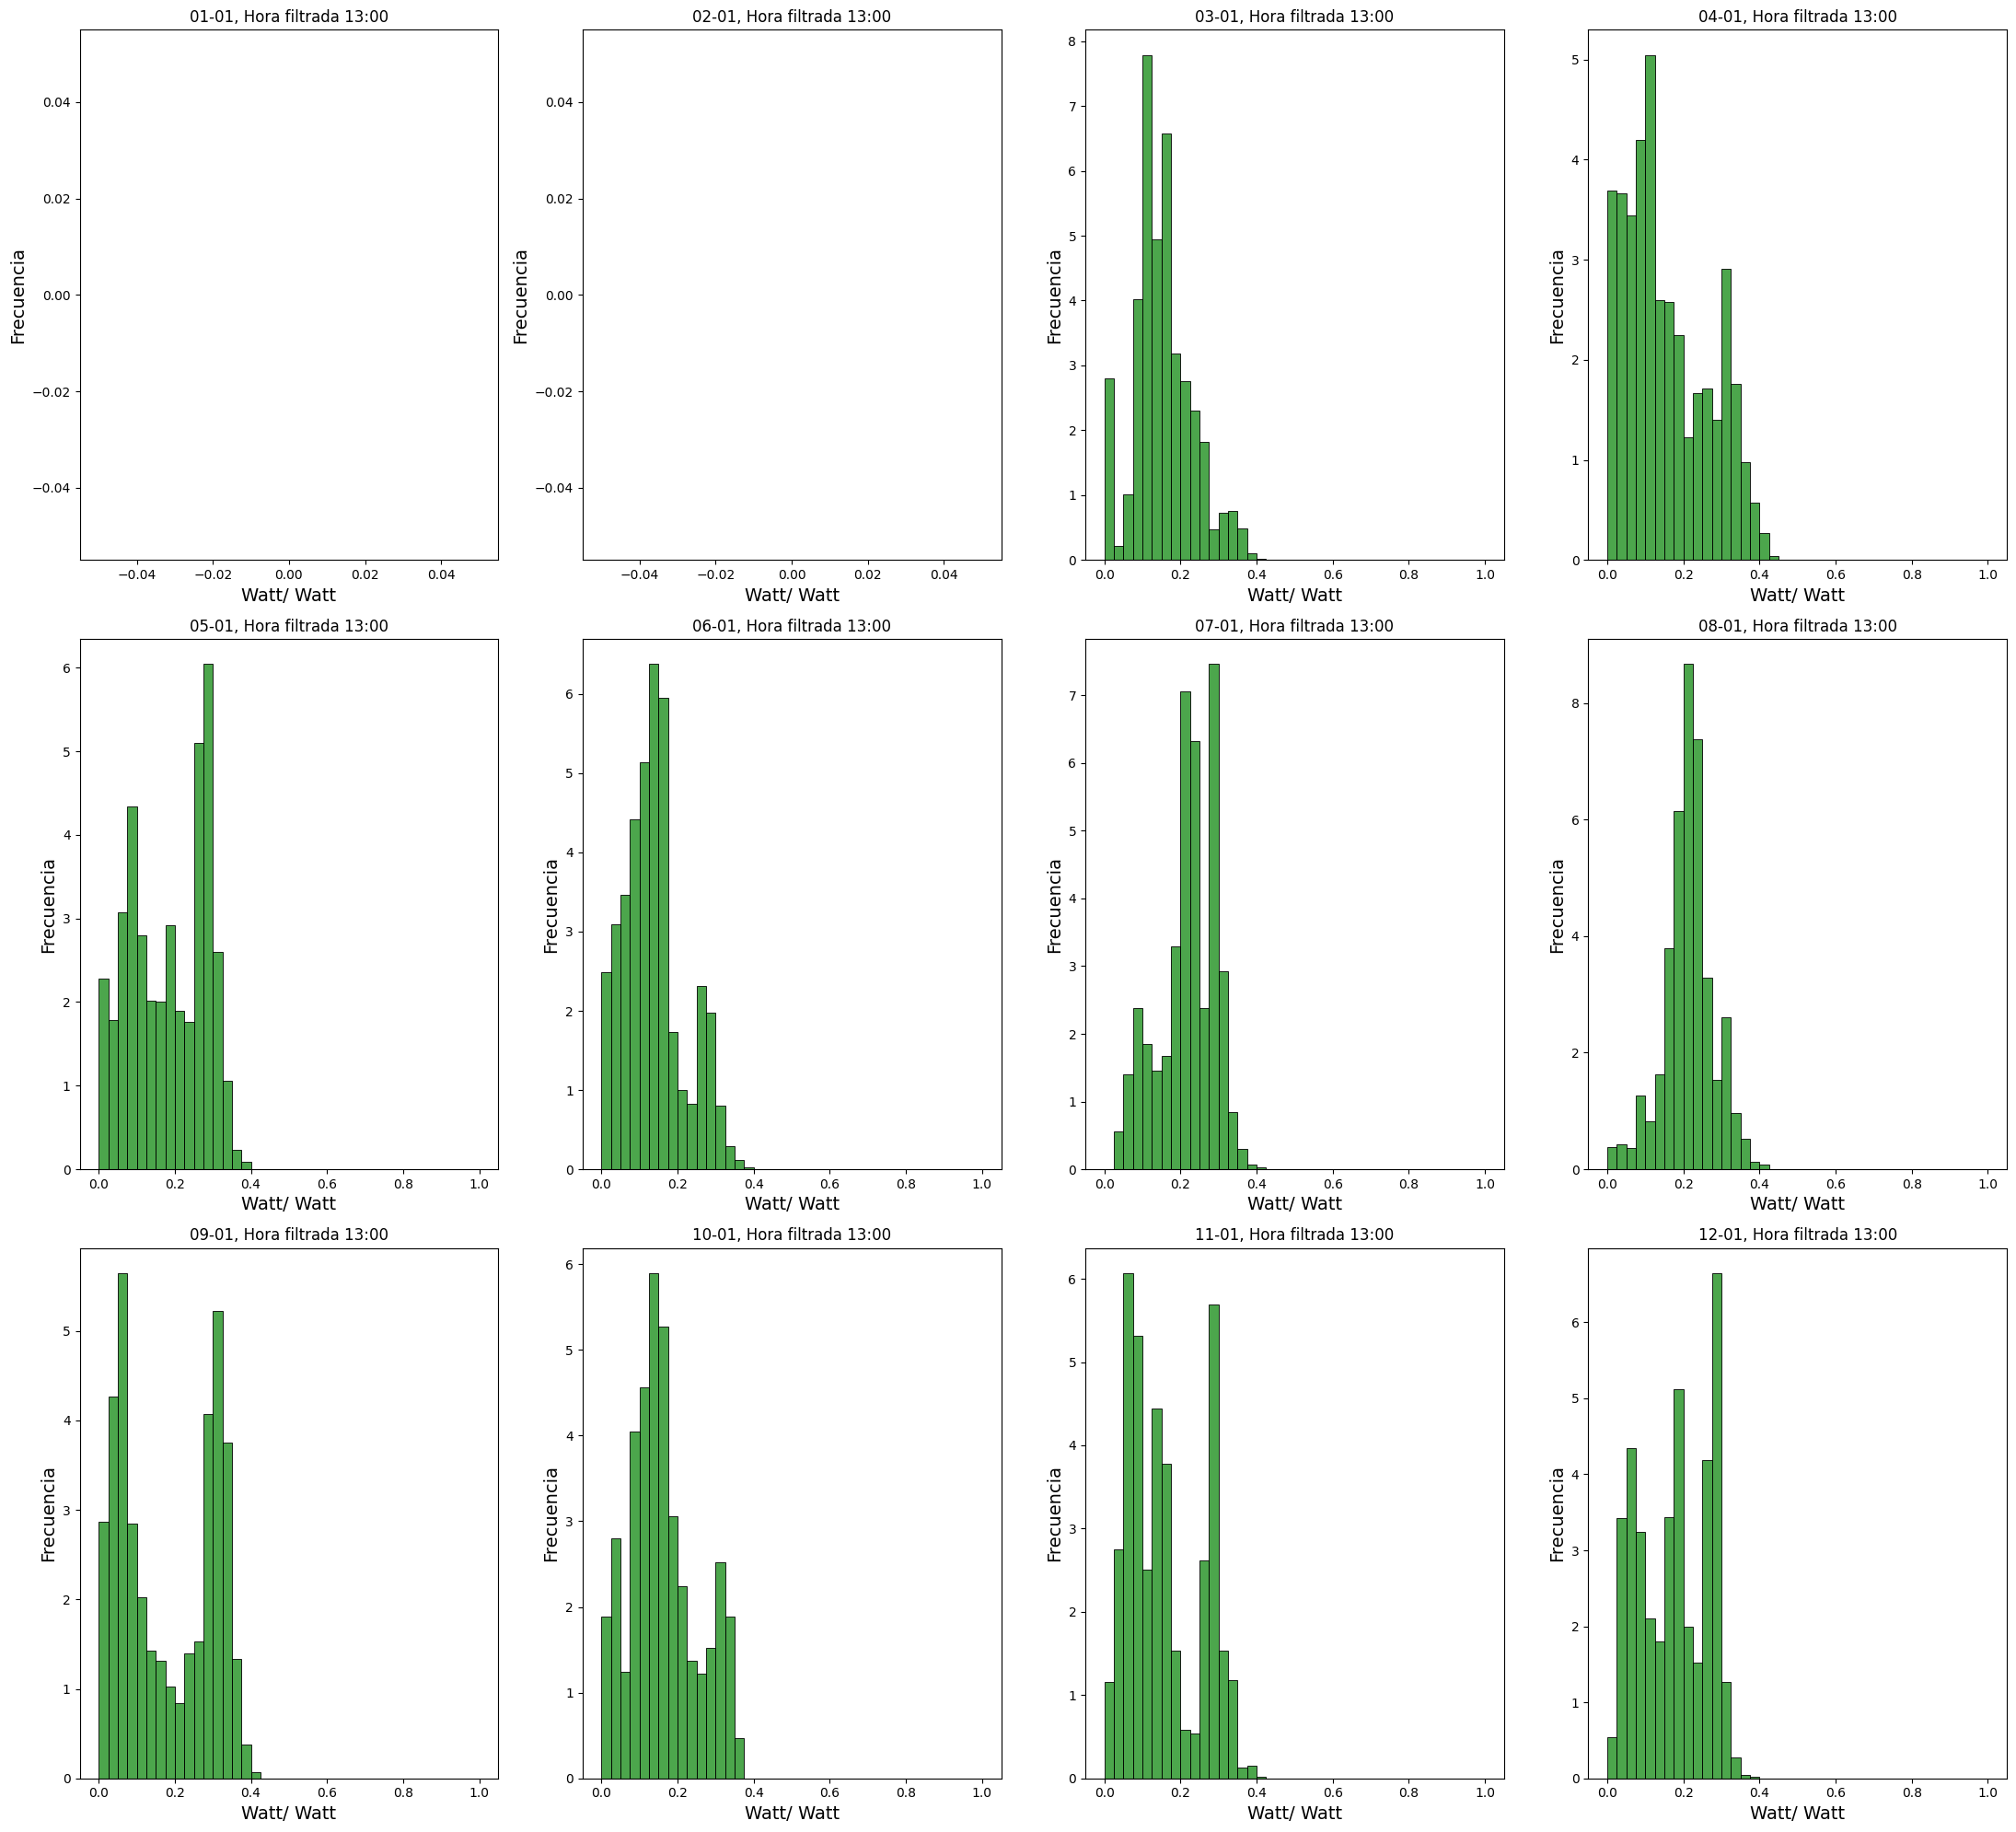

/Users/brianrodriguez/Documents/Economia/Data/AnP10_
['AnP10_Sol_PV_2023.xlsx', 'AnP10_Sol_PV_2022.xlsx', 'AnP10_Sol_PV_2021.xlsx']


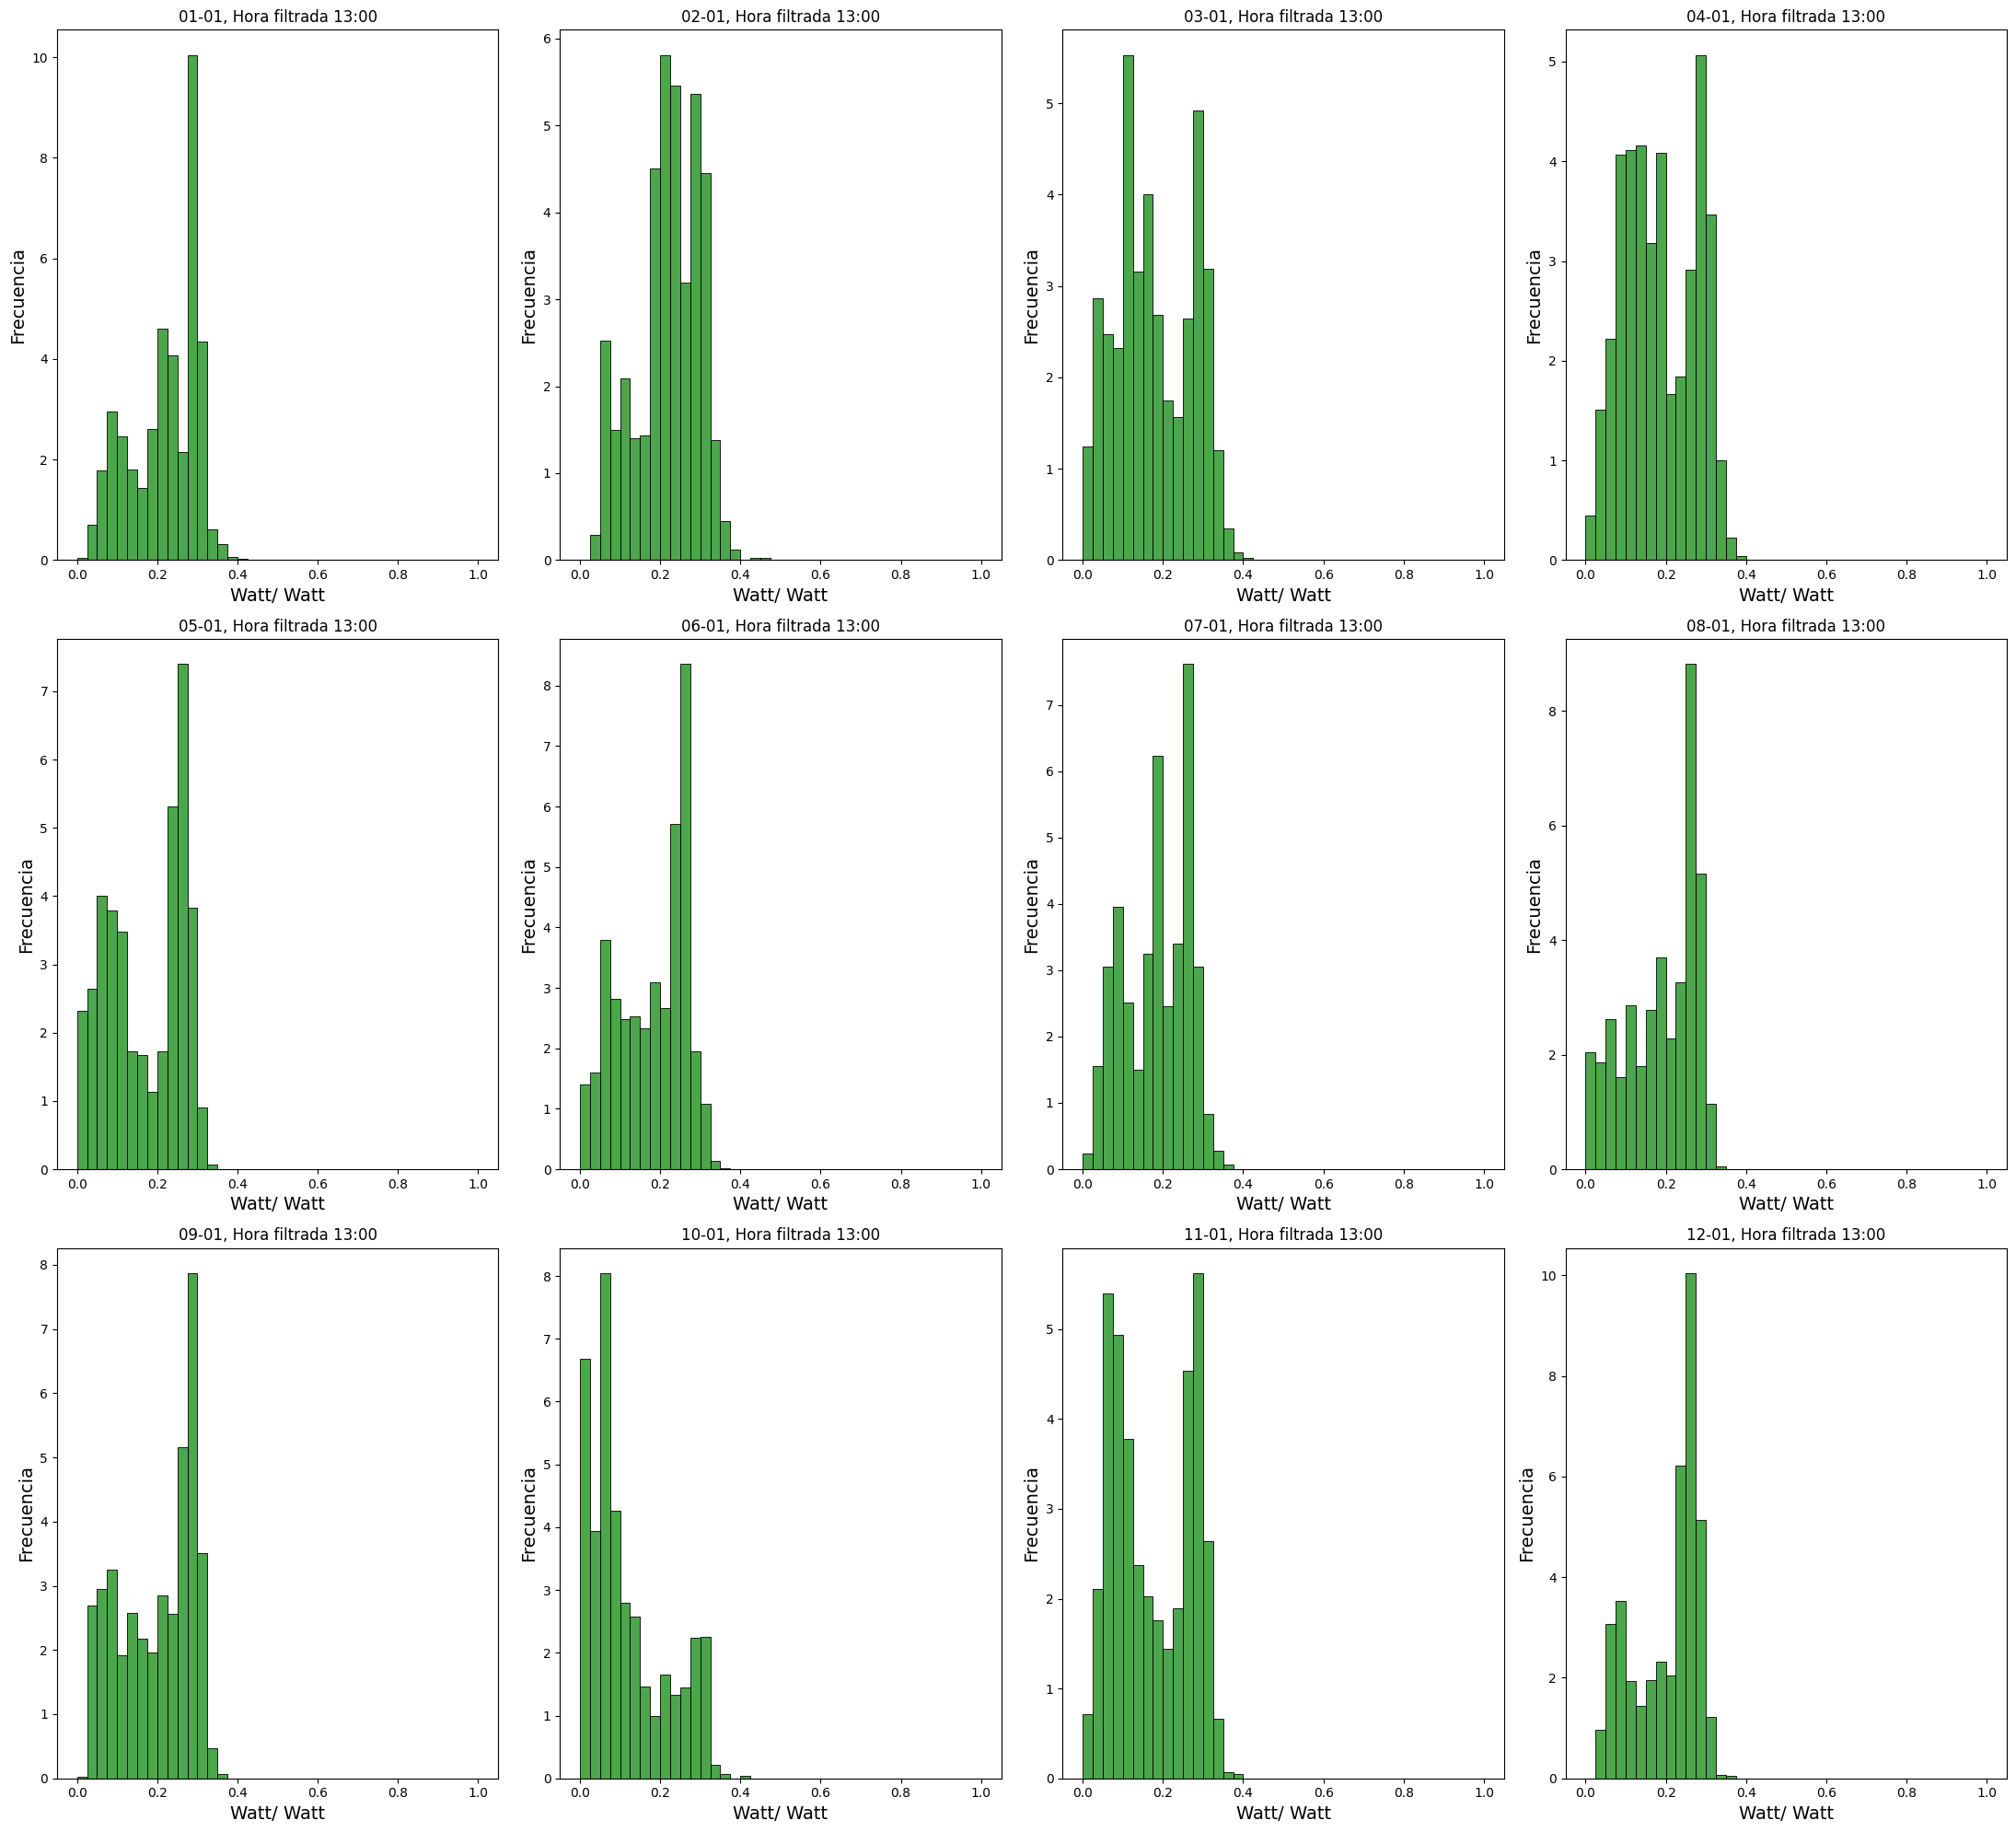

In [7]:
if __name__ == "__main__":
    analizador=["AnP01_","AnP03_","AnP04_","AnP10_"]
    potencia = [305,50,330,305]
    años = ["2021","2022","2023"]
    for i in range(len(analizador)):
        ruta = "/Users/brianrodriguez/Documents/Economia/Data/"+str(analizador[i])
        for u in range(len(años)):
            Historigrama = Histogramas_H2_(P_max_panel=potencia[i],Periodo_de_tiempo="MS",data=True,Hora_filtro=13,ruta=ruta,Columna_años=[años[u]],
                                    analizador=analizador[i])